# Siamese CNN & OCSVM

*Created by Holger Buech, Q1/2019*

**Description**   

Reimplemenation of an approach to Continuous Authentication described by [1]. It leverages a Siamese CNN to generate Deep Features, which are then used as input for an OCSVM authentication classifier.  

**Purpose**

- Verify results of [1]
- Test the approach with upfront global subject wise normalization (NAIVE_APPROACH)
- Change the normalization setting to be more realistic: Training data is normalized upfront again, but the Testing data is normalized using a single scaler fitted on training data only. (VALID_APPROACH)
- Identify parameters performing better in a valid setup than the parameters proposed by [1]. (ALTERNATIVE_APPROACH) 

**Data Sources**   

- [H-MOG Dataset](http://www.cs.wm.edu/~qyang/hmog.html)  
  (Downloaded beforehand using  [./src/data/make_dataset.py](./src/data/make_dataset.py), stored in [./data/external/hmog_dataset/](./data/external/hmog_dataset/) and converted to [./data/processed/hmog_dataset.hdf5](./data/processed/hmog_dataset.hdf5))

**References**   

- [1] Centeno, M. P. et al. (2018): Mobile Based Continuous Authentication Using Deep Features. Proceedings of the 2^nd International Workshop on Embedded and Mobile Deep Learning (EMDL), 2018, 19-24.

**Table of Contents**

**1 - [Preparations](#1)**   
1.1 - [Imports](#1.1)   
1.2 - [Configuration](#1.2)   
1.3 - [Experiment Parameters](#1.3)   
1.4 - [Select Approach](#1.4)   

**2 - [Initial Data Prepratation](#2)**   
2.1 - [Load Dataset](#2.1)   
2.2 - [Normalize Features (if global)](#2.2)   
2.3 - [Split Dataset for Valid/Test](#2.3)   
2.4 - [Normalize Features (if not global)](#2.4)   
2.5 - [Check Splits](#2.5)   
2.6 - [Reshape Features](#2.6)     

**3 - [Generate Scenario Pairs](#3)**    
3.1 - [Load cached Data](#3.1)  
3.2 - [Build positive/negative Pairs](#3.2)  
3.3 - [Inspect Pairs](#3.3)  
3.4 - [Cache Pairs](#3.4)  

**4 - [Siamese Network](#4)**  
4.1 - [Load cached Pairs](#4.1)   
4.2 - [Build Model](#4.2)   
4.3 - [Prepare Features](#4.3)   
4.4 - [Search optimal Epoch](#4.4)   
4.5 - [Check Distances](#4.5)   
4.6 - [Rebuild and train to optimal Epoch](#4.6)   
4.7 - [Cache Model](#4.7)   

**5 - [Visualize Deep Features](#5)**   
5.1 - [Load cached Data](#5.1)  
5.2 - [Extract CNN from Siamese Model](#5.2)  
5.3 - [Test Generation of Deep Features](#5.3)  
5.4 - [Visualize in 2D using PCA](#5.4)  

**6 - [OCSVM](#6)**  
6.1 - [Load cached Data](#6.1)  
6.2 - [Load trained Siamese Model](#6.2)  
6.3 - [Search for Parameters](#6.3)  
6.4 - [Inspect Search Results](#6.4) 

**7 - [Testing](#7)**  
7.1 - [Load cached Data](#7.1)  
7.2 - [Evaluate Auth Performance](#7.2)  
7.3 - [Evaluate increasing Training Set Size (Training Delay)](#7.3)  
7.4 - [Evaluate increasing Test Set Sizes (Detection Delay)](#7.4)  

**8 - [Report Results](#8)**  

## 1. Preparations <a id='1'>&nbsp;</a> 

### 1.1 Imports <a id='1.1'>&nbsp;</a> 
**Note:** The custom `DatasetLoader` is a helper class for easier loading and subsetting data from the datasets.

In [2]:
# Standard
from pathlib import Path
import os
import sys
import warnings
import random
import dataclasses
import math
import multiprocessing as mp

# Extra
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.svm import OneClassSVM
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.decomposition import PCA
import statsmodels.stats.api as sms
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import (
    Dense,
    Input,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Lambda,
    Conv2D,
    MaxPooling2D,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling1D,
    Activation
)
from keras.utils import plot_model
from keras.optimizers import Adam, SGD,RMSprop
from keras.models import load_model
from keras.callbacks import Callback
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
def trans_for_pyod (y) : 
    for i in range(len(y)): 
        if y[i] == -1: 
            y[i]=1
        elif y[i] == 1:
            y[i] = 0 
    return y 

# Custom
module_path = os.path.abspath(os.path.join(".."))  # supposed to be parent folder
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utility.dataset_loader_hdf5 import DatasetLoader

# Global utitlity functions are loaded from separate notebook:
%run utils.ipynb

### 1.2 Configuration <a id='1.2'>&nbsp;</a>

In [3]:
# Configure Data Loading & Seed
SEED = 712  # Used for every random function
HMOG_HDF5 = Path.cwd().parent / "data" / "processed" / "hmog_dataset.hdf5"
EXCLUDE_COLS = ["sys_time"]
CORES = mp.cpu_count()

# For plots and CSVs
OUTPUT_PATH = Path.cwd() / "output" / "chapter-6-1-4-siamese-cnn" / "VALIDFCNSTD2"  # Cached data & csvs
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
REPORT_PATH = Path.cwd().parent / "reports" / "figures" # Figures for thesis
REPORT_PATH.mkdir(parents=True, exist_ok=True)

# Improve performance of Tensorflow (this improved speed _a_lot_ on my machine!!!)
K.tf.set_random_seed(SEED)
conf = K.tf.ConfigProto(
    device_count={"CPU": CORES},
    allow_soft_placement=True,
    intra_op_parallelism_threads=CORES,
    inter_op_parallelism_threads=CORES,
)
K.set_session(K.tf.Session(config=conf))

# Plotting
%matplotlib inline
utils_set_output_style()

# Silence various deprecation warnings...
tf.logging.set_verbosity(tf.logging.ERROR)
np.warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")

In [4]:
# Workaround to remove ugly spacing between tqdm progress bars:
HTML("<style>.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty{padding: 0;border: 0;} div.output_subarea{padding:0;}</style>")

### 1.3 Experiment Parameters <a id='1.3'>&nbsp;</a> 
Selection of parameters set that had been tested in this notebook. Select one of them to reproduce results.

In [5]:
@dataclasses.dataclass
class ExperimentParameters:
    """Contains all relevant parameters to run an experiment."""

    name: str  # Name of Experiments Parameter set. Used as identifier for charts etc.

    # Data / Splitting:
    frequency: int
    feature_cols: list  # Columns used as features
    max_subjects: int
    exclude_subjects: list  # Don't load data from those users
    n_valid_train_subjects: int
    n_valid_test_subjects: int
    n_test_train_subjects: int
    n_test_test_subjects: int
    seconds_per_subject_train: float
    seconds_per_subject_test: float
    task_types: list  # Limit scenarios to [1, 3, 5] for sitting or [2, 4, 6] for walking, or don't limit (None)

    # Reshaping
    window_size: int  # After resampling
    step_width: int  # After resampling

    # Normalization
    scaler: str  # {"std", "robust", "minmax"}
    scaler_scope: str  # {"subject", "session"}
    scaler_global: bool  # scale training and testing sets at once (True), or fit scaler on training only (False)

    # Siamese Network
    max_pairs_per_session: int  # Max. number of pairs per session
    margin: float  # Contrastive Loss Margin
    model_variant: str  # {"1d", "2d"} Type of architecture
    filters: list  # List of length 4, containing number of filters for conv layers
    epochs_best: int  # Train epochs to for final model
    epochs_max: int
    batch_size: int
    optimizer: str  # Optimizer to use for Siamese Network
    optimizer_lr: float  # Learning Rate
    optimizer_decay: float

    # OCSVM
    ocsvm_nu: float  # Best value found in random search, used for final model
    ocsvm_gamma: float  # Best value found in random search, used for final model

    # Calculated values
    def __post_init__(self):
        # HDF key of table:
        self.table_name = f"sensors_{self.frequency}hz"

        # Number of samples per _session_ used for training:
        self.samples_per_subject_train = math.ceil(
            (self.seconds_per_subject_train * 100)
            / (100 / self.frequency)
            / self.window_size
        )

        # Number of samples per _session_ used for testing:
        self.samples_per_subject_test = math.ceil(
            (self.seconds_per_subject_test * 100)
            / (100 / self.frequency)
            / self.window_size
        )


# INSTANCES
# ===========================================================

# NAIVE_MINMAX (2D Filters)
# -----------------------------------------------------------
NAIVE_MINMAX_2D = ExperimentParameters(
    name="NAIVE-MINMAX-2D",
    # Data / Splitting
    frequency=25,
    feature_cols=[
        "acc_x",
        "acc_y",
        "acc_z",
        "gyr_x",
        "gyr_y",
        "gyr_z",
        "mag_x",
        "mag_y",
        "mag_z",
    ],
    max_subjects=90,
    exclude_subjects=[
        "733162",  # No 24 sessions
        "526319",  # ^
        "796581",  # ^
        "539502",  # Least amount of sensor values
        "219303",  # ^
        "737973",  # ^
        "986737",  # ^
        "256487",  # Most amount of sensor values
        "389015",  # ^
        "856401",  # ^
    ],
    n_valid_train_subjects=40,
    n_valid_test_subjects=10,
    n_test_train_subjects=10,
    n_test_test_subjects=30,
    seconds_per_subject_train=67.5,
    seconds_per_subject_test=67.5,
    task_types=None,
    # Reshaping
    window_size=25,  # 1 sec
    step_width=25,
    # Normalization
    scaler="minmax",
    scaler_scope="subject",
    scaler_global=True,
    # Siamese Network
    model_variant="2d",
    filters=[32, 64, 128, 32],
    epochs_best=35,
    epochs_max=40,
    batch_size=200,
    optimizer="sgd",
    optimizer_lr=0.01,
    optimizer_decay=0,
    max_pairs_per_session=60,  # => 4min
    margin=0.2,
    # OCSVM
    ocsvm_nu=0.092,
    ocsvm_gamma=1.151,
)  # <END NAIVE_APPROACH>

# VALID_MINMAX (2D)
# -----------------------------------------------------------
VALID_MINMAX_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-MINMAX-2D",
    task_types=None,
    scaler_global=False,
    epochs_max=40,
    ocsvm_nu=0.110,
    ocsvm_gamma=59.636,
)

# NAIVE_ROBUST (2D)
# -----------------------------------------------------------
NAIVE_ROBUST_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="NAIVE-ROBUST-2D",
    scaler="robust",
    optimizer="sgd",
    optimizer_lr=0.05, # Decreased, to avoid "all zeros" prediction
    optimizer_decay=0.002,
    epochs_best=5,
    ocsvm_nu=0.214,
    ocsvm_gamma=2.354,
)

# VALID_ROBUST (2D)
# -----------------------------------------------------------
VALID_ROBUST_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-ROBUST-2D",
    scaler="robust",
    scaler_global=False,
    epochs_best=6,
    epochs_max=20,
    optimizer="sgd",
    optimizer_lr=0.05,  # Decrease LR, to avoid "all zeros" prediction
    optimizer_decay=0.002,
    ocsvm_nu=0.190,
    ocsvm_gamma=0.069,
)

# VALID_ROBUST (1D)
# -----------------------------------------------------------
VALID_ROBUST_1D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-ROBUST-1D",
    scaler="robust",
    scaler_global=False,
    model_variant="1d", 
    filters=[32, 64, 128, 64],    
    epochs_best=9,
    epochs_max=20,
    ocsvm_nu=0.156,
    ocsvm_gamma=33.932,
)

# FCN_ROBUST (1D)
# -----------------------------------------------------------
VALID_FCN_ROBUST = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[2, 4, 6],
    feature_cols=["acc_x", "acc_y", "acc_z"], 
    frequency=25,
    window_size=25*5,
    step_width=25*5,
    scaler="robust",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.001,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.165,
    ocsvm_gamma=8.296,
)



# FCN_ROBUST (1D) ACC_MAG 
# -----------------------------------------------------------
VALID_FCN_ROBUST_ACCMAG = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL-ACCMAG",
    task_types=[2, 4, 6],
    feature_cols=["acc_x", "acc_y", "acc_z","mag_x", "mag_y", "mag_z"], 
    frequency=25,
    window_size=25*5,
    step_width=25*5,
    scaler="robust",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.001,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.165,
    ocsvm_gamma=8.296,
)

# FCN_ROBUST (1D) ACC_GYR 
# -----------------------------------------------------------
VALID_FCN_ROBUST_ACCGYR = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL-ACCGYR",
    task_types=[2, 4, 6],
    feature_cols=["acc_x", "acc_y", "acc_z","gyr_x", "gyr_y", "gyr_z"], 
    frequency=25,
    window_size=25*5,
    step_width=25*5,
    scaler="robust",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.001,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.165,
    ocsvm_gamma=8.296,
)


# FCN_MinMax (1D)  
# -----------------------------------------------------------
VALID_FCN_MINMAX = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-MINMAX",
    task_types=[2, 4, 6],
    feature_cols=["acc_x", "acc_y", "acc_z"], 
    frequency=25,
    window_size=25*5,
    step_width=25*5,
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.001,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.165,
    ocsvm_gamma=8.296,
)



VALID_FCN_std = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-std",
    scaler="std",
    task_types=[2, 4, 6],
    feature_cols=["acc_x", "acc_y", "acc_z"], 
    frequency=25,
    window_size=25*5,
    step_width=25*5,
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.001,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.165,
    ocsvm_gamma=8.296,
)

### 1.4 Select Approach <a id='1.4'>&nbsp;</a> 
Select the parameters to use for current notebook execution here!

In [6]:
P = VALID_FCN_std
#VALID_FCN_ROBUST_ACCGYR
#NAIVE_MINMAX_2D#VALID_FCN_ROBUST

**Overview of current Experiment Parameters:**

In [7]:
utils_ppp(P)

,Value
batch_size,300
epochs_best,40
epochs_max,80
exclude_subjects,"[733162, 526319, 796581, 539502, 219303, 73797..."
feature_cols,"[acc_x, acc_y, acc_z]"
filters,"[32, 64, 32]"
frequency,25
margin,1
max_pairs_per_session,600
max_subjects,90


## 2. Initial Data Preparation <a id='2'>&nbsp;</a> 

### 2.1 Load Dataset <a id='2.1'>&nbsp;</a> 

In [8]:
hmog = DatasetLoader(
    hdf5_file=HMOG_HDF5,
    table_name=P.table_name,
    max_subjects=P.max_subjects,
    task_types=P.task_types,
    exclude_subjects=P.exclude_subjects,
    exclude_cols=EXCLUDE_COLS,
    seed=SEED,
)
hmog.data_summary()

,DataFrame,Memory (MB),Rows,Columns,Subjects,Sessions
0,all,1437.64,14494937,12,90,1080
1,index,0.08,2160,4,90,2160


### 2.2 Normalize Features (if global) <a id='2.2'>&nbsp;</a> 
Used here for naive approach (before splitting into test and training sets). Otherwise it's used during generate_pairs() and respects train vs. test borders.

In [9]:
if P.scaler_global:
    print("Normalize all data before splitting into train and test sets...")
    hmog.all, scalers = utils_custom_scale(
        hmog.all,
        scale_cols=P.feature_cols,        
        feature_cols=P.feature_cols,
        scaler_name=P.scaler,
        scope=P.scaler_scope,
        plot=True,
    )
else:
    print("Skipped, normalize after splitting.")

Skipped, normalize after splitting.


### 2.3 Split Dataset for Valid/Test <a id='2.3'>&nbsp;</a> 
In two splits: one used during hyperparameter optimization, and one used during testing.

The split is done along the subjects: All sessions of a single subject will either be in the validation split or in the testing split, never in both.

In [10]:
hmog.split_train_valid_train_test(
    n_valid_train=P.n_valid_train_subjects,
    n_valid_test=P.n_valid_test_subjects,
    n_test_train=P.n_test_train_subjects,
    n_test_test=P.n_test_test_subjects,
)
hmog.data_summary()

,DataFrame,Memory (MB),Rows,Columns,Subjects,Sessions
0,index,0.08,2160,4,90,2160
1,valid_train,652.12,6575003,12,40,480
2,valid_test,148.80,1500294,12,10,120
3,test_train,160.42,1617398,12,10,120
4,test_test,476.30,4802242,12,30,360


### 2.4 Normalize features (if not global) <a id='2.4'>&nbsp;</a> 

Scaling Data for Siamese Network only...
Training Data:
Before Scaling:


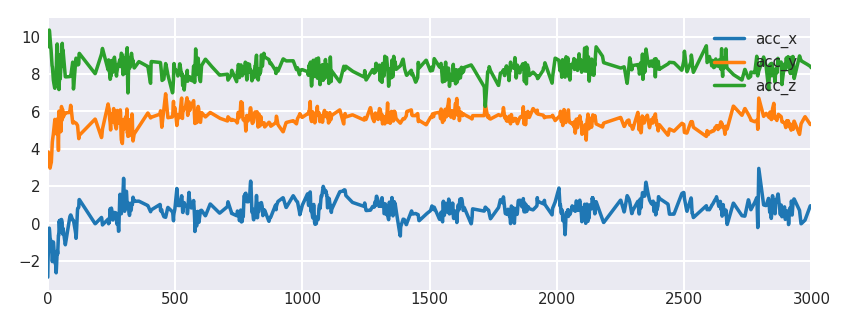

After Scaling:


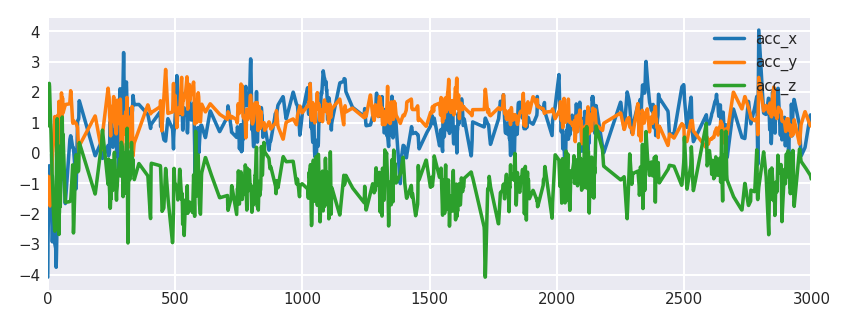

Validation Data:
Before Scaling:


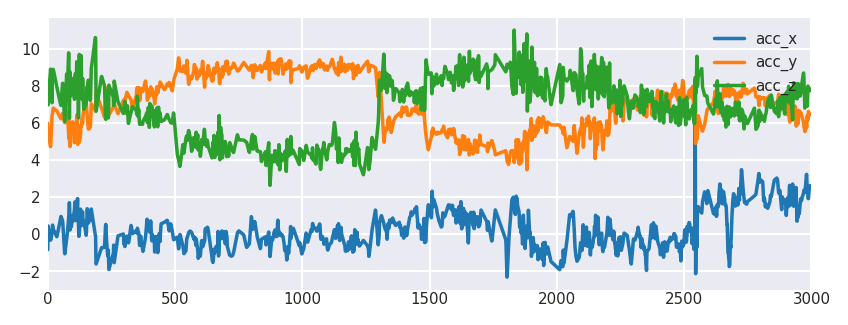

After Scaling:


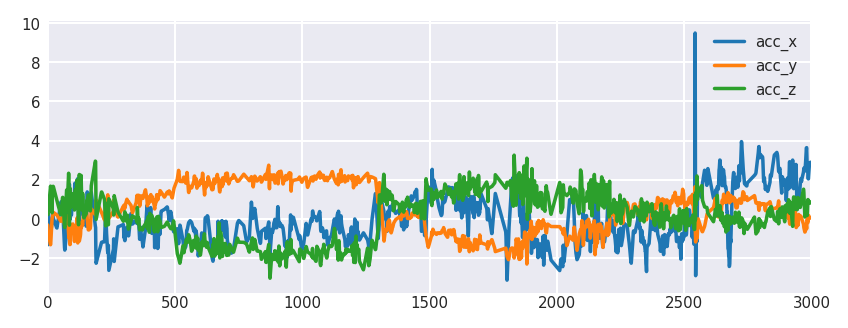

In [11]:
if not P.scaler_global:
    print("Scaling Data for Siamese Network only...")
    print("Training Data:")
    hmog.valid_train, _ = utils_custom_scale(
        hmog.valid_train,
        scale_cols=P.feature_cols,
        feature_cols=P.feature_cols,
        scaler_name=P.scaler,
        scope=P.scaler_scope,
        plot=True,        
    )
    print("Validation Data:")
    hmog.valid_test, _ = utils_custom_scale(
        hmog.valid_test,
        scale_cols=P.feature_cols,        
        feature_cols=P.feature_cols,
        scaler_name=P.scaler,
        scope=P.scaler_scope,
        plot=True,        
    )
else:
    print("Skipped, already normalized.")    

### 2.5 Check Splits <a id='2.5'>&nbsp;</a> 

In [12]:
utils_split_report(hmog.valid_train)

Unique subjects: 40
Unique sessions: 480

Head:


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,subject,session,task_type
0,-4.083759,-1.312809,1.102806,-0.601588,0.193339,0.149184,-4.416808,-18.677058,4.042481,865501,865501_session_12,6
1,-2.877333,-0.767760,1.738687,-0.300374,0.114175,0.497483,-4.240847,-17.911847,3.674885,865501,865501_session_12,6
2,-2.424739,-0.770633,1.467698,-0.160162,0.136490,0.434803,-4.053154,-17.692154,3.456116,865501,865501_session_12,6
3,-2.023645,-0.814173,1.143037,0.111769,0.138812,0.265335,-3.856505,-17.486192,3.230707,865501,865501_session_12,6
4,-1.607197,-0.861182,0.891359,0.102549,0.301903,0.182352,-3.562962,-17.466766,2.962154,865501,865501_session_12,6




Sessions' Task Types per subject:


subject,100669,171538,218719,220962,240168,248252,326223,352716,366286,405035,431312,472761,525584,540641,553321,554303,588087,621276,622852,663153,675397,693572,717868,733568,745224,751131,763813,771782,803262,856302,862649,865501,865881,876011,892687,897652,913228,962159,973891,980953
2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
6,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


In [13]:
utils_split_report(hmog.valid_test)

Unique subjects: 10
Unique sessions: 120

Head:


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,subject,session,task_type
0,-1.333109,-0.321446,0.248488,-0.068970,-0.272866,0.453358,3.777375,6.74075,-11.045000,808022,808022_session_14,2
1,0.236960,-0.724440,0.215207,-0.193158,-0.035115,0.200259,3.496544,6.55200,-11.031676,808022,808022_session_14,2
2,0.143120,-0.785060,0.360252,-0.172092,0.001737,0.063053,3.292662,6.55200,-10.996147,808022,808022_session_14,2
3,0.049279,-0.845681,0.505297,-0.149948,0.041291,-0.003073,3.088779,6.55200,-10.960618,808022,808022_session_14,2
4,-0.044561,-0.906302,0.650342,-0.127805,0.080844,-0.069199,2.884897,6.55200,-10.925088,808022,808022_session_14,2




Sessions' Task Types per subject:


subject,277905,396697,489146,578526,594887,776328,777078,799296,808022,923862
2,4,4,4,4,4,4,4,4,4,4
4,4,4,4,4,4,4,4,4,4,4
6,4,4,4,4,4,4,4,4,4,4


In [14]:
utils_split_report(hmog.test_train)

Unique subjects: 10
Unique sessions: 120

Head:


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,subject,session,task_type
0,0.688068,4.688514,9.120988,-0.078252,0.450208,0.695653,6.23400,-14.868125,-34.456750,785873,785873_session_10,4
1,0.542114,4.478009,9.112148,-0.152533,0.455095,0.571525,6.23400,-14.988458,-34.565417,785873,785873_session_10,4
2,0.396160,4.267503,9.103308,-0.226814,0.459982,0.447397,6.23400,-15.108792,-34.674083,785873,785873_session_10,4
3,0.250206,4.056998,9.094467,-0.301096,0.464868,0.323270,6.36225,-15.248875,-34.742000,785873,785873_session_10,4
4,0.104251,3.846492,9.085627,-0.275299,0.499977,0.278209,6.70425,-15.421875,-34.742000,785873,785873_session_10,4




Sessions' Task Types per subject:


subject,186676,201848,264325,368258,698266,710707,785873,815316,827212,879155
2,4,4,4,4,4,4,4,4,4,4
4,4,4,4,4,4,4,4,4,4,4
6,4,4,4,4,4,4,4,4,4,4


In [15]:
utils_split_report(hmog.test_test)

Unique subjects: 30
Unique sessions: 360

Head:


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,subject,session,task_type
0,-0.204404,5.035904,8.418314,-0.077475,-0.044569,-0.019363,-27.751167,15.160111,-2.113555,579284,579284_session_1,4
1,-0.354591,5.342461,8.230168,0.021356,0.016582,-0.022128,-28.052944,14.979074,-2.555037,579284,579284_session_1,4
2,-0.351473,5.612957,8.443053,0.120188,0.077733,-0.024893,-28.354722,14.798037,-2.996518,579284,579284_session_1,4
3,-0.104447,5.637447,8.342297,0.219019,0.138883,-0.027658,-28.656500,14.617000,-3.437999,579284,579284_session_1,4
4,0.059905,5.838211,8.536127,0.317851,0.200034,-0.030423,-28.958277,14.435963,-3.879481,579284,579284_session_1,4




Sessions' Task Types per subject:


subject,151985,180679,207696,257279,261313,278135,336172,342329,395129,398248,501973,527796,538363,556357,561993,579284,657486,720193,785899,841866,863985,872895,893198,893255,918136,937904,966655,984799,990622,998757
2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
6,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


### 2.6 Reshape Features  <a id='2.6'>&nbsp;</a> 

**Reshape & cache Set for Training Siamese Network:**

In [16]:
df_siamese_train = utils_reshape_features(
    hmog.valid_train,
    feature_cols=P.feature_cols,
    window_size=P.window_size,
    step_width=P.step_width,
)

# Clean memory
del hmog.train
%reset_selective -f hmog.train

print("Validation data after reshaping:")
display(df_siamese_train.head())

# Store iterim data
df_siamese_train.to_msgpack(OUTPUT_PATH / "NAIVE_df_siamese_train.msg")

# Clean memory
%reset_selective -f df_siamese_train

Validation data after reshaping:


,X,subject,session,task_type
0,"[[1.5090727765207808, -7.8080316840874735, 3.9...",100669,100669_session_12,6
1,"[[0.4748612115811462, -1.709391856279853, 0.86...",100669,100669_session_12,6
2,"[[0.6898934143769581, -2.290170078758669, 0.82...",100669,100669_session_12,6
3,"[[-1.258561016530285, -3.04582843516075, 1.416...",100669,100669_session_12,6
4,"[[0.000469152975803837, -2.905744016013536, 1....",100669,100669_session_12,6


**Reshape & cache Set for Validating Siamese Network:** (also used to optimize OCSVM)

In [17]:
df_siamese_valid = utils_reshape_features(
    hmog.valid_test,
    feature_cols=P.feature_cols,
    window_size=P.window_size,
    step_width=P.step_width,
)

del hmog.valid
%reset_selective -f hmog.valid

print("Testing data after reshaping:")
display(df_siamese_valid.head())

# Store iterim data
df_siamese_valid.to_msgpack(OUTPUT_PATH / "NAIVE_df_siamese_valid.msg")

# Clean memory
%reset_selective -f df_siamese_valid

Testing data after reshaping:


,X,subject,session,task_type
0,"[[0.3105341497265119, 1.1823709599270098, 1.96...",277905,277905_session_11,6
1,"[[-0.37079849034844636, 0.8847662653578702, -0...",277905,277905_session_11,6
2,"[[0.24611501238438765, -0.6848532543792285, 1....",277905,277905_session_11,6
3,"[[1.3116538254493977, -0.044850308152980134, 0...",277905,277905_session_11,6
4,"[[-0.6076592697239253, 0.17452612823635397, -0...",277905,277905_session_11,6


**Reshape & cache Set for Training/Validation OCSVM:**

In [18]:
df_ocsvm_train_valid = utils_reshape_features(
    hmog.test_train,
    feature_cols=P.feature_cols,
    window_size=P.window_size,
    step_width=P.step_width,
)

del hmog.test_train
%reset_selective -f hmog.test_train

print("Testing data after reshaping:")
display(df_ocsvm_train_valid.head())

# Store iterim data
df_ocsvm_train_valid.to_msgpack(OUTPUT_PATH / "NAIVE_df_ocsvm_train_valid.msg")

# Clean memory
%reset_selective -f df_ocsvm_train_valid

Testing data after reshaping:


,X,subject,session,task_type
0,"[[-8.607810569636623, 0.9955167241816556, -1.9...",186676,186676_session_1,4
1,"[[-0.3209477333333335, 3.128859958333334, 9.44...",186676,186676_session_1,4
2,"[[-2.057314, 4.621461133928572, 7.006203626785...",186676,186676_session_1,4
3,"[[0.534176783756579, 6.0081232518346415, 8.295...",186676,186676_session_1,4
4,"[[-1.53348510239776, 5.71207867121504, 8.14309...",186676,186676_session_1,4


**Reshape & cache Set for Training/Testing OCSVM:**

In [19]:
df_ocsvm_train_test = utils_reshape_features(
    hmog.test_test,
    feature_cols=P.feature_cols,
    window_size=P.window_size,
    step_width=P.step_width,
)

del hmog.test_test
%reset_selective -f hmog.test_test

print("Testing data after reshaping:")
display(df_ocsvm_train_test.head())

# Store iterim data
df_ocsvm_train_test.to_msgpack(OUTPUT_PATH / "NAIVE_df_ocsvm_train_test.msg")

# Clean memory
%reset_selective -f df_ocsvm_train_test
%reset_selective -f df_

Testing data after reshaping:


,X,subject,session,task_type
0,"[[-0.3765385456074766, 3.1107421714953274, 7.7...",151985,151985_session_10,6
1,"[[0.09549826478869189, 3.9700954602219136, 7.7...",151985,151985_session_10,6
2,"[[0.20883461625482397, 3.2271731154792, 8.6506...",151985,151985_session_10,6
3,"[[0.0038022012564349096, 3.0280049158538764, 9...",151985,151985_session_10,6
4,"[[-2.4728418720348535, 3.5376784001577266, 7.4...",151985,151985_session_10,6


## 3. Generate Scenario Pairs <a id='3'>&nbsp;</a> 

### 3.1 Load cached Data <a id='3.1'>&nbsp;</a> 

In [20]:
df_siamese_train = pd.read_msgpack(OUTPUT_PATH / "NAIVE_df_siamese_train.msg")
df_siamese_valid = pd.read_msgpack(OUTPUT_PATH / "NAIVE_df_siamese_valid.msg")

### 3.2 Build positive/negative Pairs  <a id='3.2'>&nbsp;</a> 

In [21]:
def build_pairs(df):
    # Limit samples per subject to sample of shortest session
    df = df.groupby("session", group_keys=False).apply(
        lambda x: x.sample(min(len(x), P.max_pairs_per_session), random_state=SEED)
    )
    df_pairs = None

    # Split samples subject wise 50:50
    # ---------------
    df_positives = None
    df_negatives = None

    for subject in df["subject"].unique():
        # Shuffle
        df_subj = df[df["subject"] == subject].sample(frac=1, random_state=SEED)

        # Make rows even
        if len(df_subj) % 2 != 0:
            df_subj = df_subj.iloc[:-1]

        half = len(df_subj) // 2

        df_positives = pd.concat([df_positives, df_subj.iloc[:half]])
        df_negatives = pd.concat([df_negatives, df_subj.iloc[half:]])

    # Positive Pairs
    # ---------------
    df_positive_left = None
    df_positive_right = None

    for subject in df_positives["subject"].unique():
        df_subj = df[df["subject"] == subject]
        # Make rows even
        if len(df_subj) % 2 != 0:
            df_subj = df_subj.iloc[:-1]

        # Split in half
        half = len(df_subj) // 2
        df_positive_left = pd.concat([df_positive_left, df_subj.iloc[:half]])
        df_positive_right = pd.concat([df_positive_right, df_subj.iloc[half:]])

    df_positive_left = df_positive_left.reset_index(drop=True)
    df_positive_right = df_positive_right.reset_index(drop=True)
    df_positive_left.columns = ["left_" + c for c in df_positive_left.columns]
    df_positive_right.columns = ["right_" + c for c in df_positive_right.columns]

    df_positives = pd.concat(
        [df_positive_left, df_positive_right],
        axis=1,
        sort=False,
        join_axes=[df_positive_left.index],
    )

    # Negative Pairs
    # ---------------
    # Make rows even
    if len(df_negatives) % 2 != 0:
        df_negatives = df_negatives.iloc[:-1]

    # Split in half
    half = len(df_negatives) // 2
    df_negative_left = df_negatives.iloc[half:].reset_index(drop=True)
    df_negative_right = df_negatives.iloc[:half].reset_index(drop=True)

    # Name columns
    df_negative_left.columns = ["left_" + c for c in df_negative_left.columns]
    df_negative_right.columns = ["right_" + c for c in df_negative_right.columns]

    # Combine
    df_negatives = pd.concat(
        [df_negative_left, df_negative_right],
        axis=1,
        sort=False,
        join_axes=[df_negative_left.index],
    )

    # Combine both Pairs
    # ---------------
    # Balance pairs
    min_len = min(len(df_positives), len(df_negatives))
    df_positives = df_positives.sample(n=min_len, random_state=SEED)
    df_negatives = df_negatives.sample(n=min_len, random_state=SEED)

    # Combine
    df_pairs = pd.concat([df_positives, df_negatives], sort=False)

    # Shuffle
    df_pairs = df_pairs.sample(frac=1, random_state=SEED).reset_index(drop=True)

    # Set Label
    df_pairs["label"] = np.where(
        df_pairs["left_subject"] == df_pairs["right_subject"], 1, 0
    )

    return df_pairs

In [22]:
# Reduce observations/samples per
print("Sample per session before reduction:\n ")
display(df_siamese_train["session"].value_counts().head(3))
display(df_siamese_valid["session"].value_counts().head(3))

df_siamese_train = df_siamese_train.groupby("session", group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), P.samples_per_subject_train), random_state=SEED)
)

df_siamese_valid = df_siamese_valid.groupby("session", group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), P.samples_per_subject_test), random_state=SEED)
)

print("\n\nSample per session after reduction:\n")
display(df_siamese_train["session"].value_counts().head(3))
display(df_siamese_valid["session"].value_counts().head(3))

Sample per session before reduction:
 


771782_session_5    449
733568_session_2    417
876011_session_4    339
Name: session, dtype: int64

396697_session_1    330
489146_session_4    232
489146_session_5    196
Name: session, dtype: int64



Sample per session after reduction:



675397_session_1    120
973891_session_1    120
100669_session_6    120
Name: session, dtype: int64

489146_session_11    120
277905_session_3     120
489146_session_6     120
Name: session, dtype: int64

In [23]:
df_siamese_train_pairs = build_pairs(df_siamese_train)
df_siamese_valid_pairs = build_pairs(df_siamese_valid)

### 3.3 Inspect Pairs <a id='3.3'>&nbsp;</a> 

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23202 entries, 0 to 23201
Data columns (total 9 columns):
left_X             23202 non-null object
left_subject       23202 non-null object
left_session       23202 non-null object
left_task_type     23202 non-null int64
right_X            23202 non-null object
right_subject      23202 non-null object
right_session      23202 non-null object
right_task_type    23202 non-null int64
label              23202 non-null int64
dtypes: int64(3), object(6)
memory usage: 1.6+ MB


None



Head:


,left_X,left_subject,left_session,left_task_type,right_X,right_subject,right_session,right_task_type,label
0,"((-0.9285741702328191, 0.565355661590921, -0.8...",763813,763813_session_3,4,"((0.3935709933234001, 2.566695464789691, -3.59...",248252,248252_session_15,4,0
1,"((0.6007282528126705, 0.8039529248020744, -0.6...",862649,862649_session_11,6,"((1.5816268062988017, 0.4609736426363774, 0.29...",862649,862649_session_20,2,1
2,"((-1.3683746877487626, 0.47360589949799964, -0...",248252,248252_session_1,6,"((-0.7313225028023534, -0.4369080645765709, 0....",248252,248252_session_21,2,1
3,"((-0.519562868093176, -0.2933649200655467, 1.0...",751131,751131_session_2,6,"((0.7897493009836114, 0.41360200474785547, -1....",240168,240168_session_13,4,0
4,"((0.8333560574567187, 1.239725586311663, -0.95...",865501,865501_session_12,6,"((-0.47144814135692925, -0.5333167629095606, 0...",865501,865501_session_22,4,1




Any NaN values?


left_X             0
left_subject       0
left_session       0
left_task_type     0
right_X            0
right_subject      0
right_session      0
right_task_type    0
label              0
dtype: int64




Distribution of Samples per Subjects in training Data


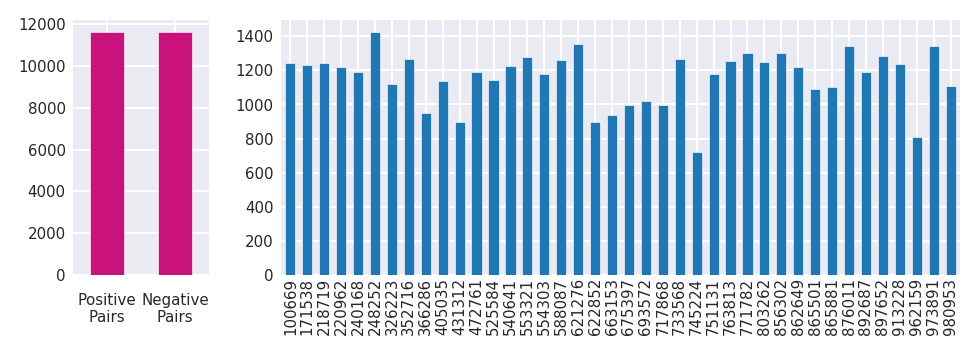

In [24]:
print("DataFrame Info:")
display(df_siamese_train_pairs.info())

print("\n\nHead:")
display(df_siamese_train_pairs.head(5))

print("\n\nAny NaN values?")
display(df_siamese_train_pairs.isnull().sum(axis = 0))

df_left_sub = df_siamese_train_pairs.groupby("left_subject")["left_subject"].count()
df_right_sub = df_siamese_train_pairs.groupby("right_subject")["right_subject"].count()
df_temp = pd.concat([df_left_sub, df_right_sub])

print("\n\n\nDistribution of Samples per Subjects in training Data")

fig, axes = plt.subplots(
    ncols=2, nrows=1, figsize=(5.473, 2), dpi=180, gridspec_kw={"width_ratios": [1, 5]}
)
df_siamese_train_pairs["label"].value_counts().rename(
    index={0: "Negative\nPairs", 1: "Positive\nPairs"}
).plot.bar(ax=axes[0], rot=0, color=MAGENTA)
axes[0].tick_params(axis="x", which="major", pad=7)
df_temp.groupby(df_temp.index).sum().plot.bar(ax=axes[1], width=0.6)
fig.tight_layout()

utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-pair-dist.pdf")

### 3.4 Cache Pairs <a id='3.4'>&nbsp;</a> 

In [25]:
df_siamese_train_pairs.to_msgpack(OUTPUT_PATH / "NAIVE_df_siamese_train_pairs.msg")
df_siamese_valid_pairs.to_msgpack(OUTPUT_PATH / "NAIVE_df_siamese_valid_pairs.msg")

In [26]:
# Clean Memory
%reset_selective -f df_

## 4. Siamese Network <a id='4'>&nbsp;</a> 

### 4.1 Load cached Pairs <a id='4.1'>&nbsp;</a> 

In [27]:
df_siamese_train_pairs = pd.read_msgpack(OUTPUT_PATH / "NAIVE_df_siamese_train_pairs.msg")
df_siamese_valid_pairs = pd.read_msgpack(OUTPUT_PATH / "NAIVE_df_siamese_valid_pairs.msg")

### 4.2 Build Model <a id='4.2'>&nbsp;</a> 

#### Distance Function

In [28]:
def k_euclidean_dist(t):
    x = t[0]
    y = t[1]    
    return K.sqrt(K.sum(K.square(x - y), axis=-1, keepdims=True))

#### Loss Function

In [29]:
def k_contrastive_loss(y_true, dist):
    """Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """
    margin = P.margin
    return K.mean(y_true * K.square(dist) + (1 - y_true) * K.square(K.maximum(margin - dist, 0)))

Sanity check contrastive loss function:

In [30]:
def contrastive_loss_test(y_true, dist):
    """Test function above using implementation with numpy instead tensors."""
    margin = P.margin
    return y_true * np.square(dist) + (1 - y_true) * np.square(np.max(margin - dist, 0))

In [31]:
print("Positive: class=1, distance=0,     loss:", contrastive_loss_test(1, 0))
print("Positive: class=1, distance=0.01,  loss:", contrastive_loss_test(1, 0.01))
print("Positive: class=1, distance=0.3,   loss:", contrastive_loss_test(1, 0.3))
print("Positive: class=1, distance=0.5,   loss:", contrastive_loss_test(1, 0.5))
print("Positive: class=1, distance=1,     loss:", contrastive_loss_test(1, 1))

Positive: class=1, distance=0,     loss: 0
Positive: class=1, distance=0.01,  loss: 0.0001
Positive: class=1, distance=0.3,   loss: 0.09
Positive: class=1, distance=0.5,   loss: 0.25
Positive: class=1, distance=1,     loss: 1


In [32]:
print("Negative: class=0, distance=0,     loss:", contrastive_loss_test(0, 0))
print("Negative: class=0, distance=0.01,  loss:", contrastive_loss_test(0, 0.01))
print("Negative: class=0, distance=0.3,   loss:", contrastive_loss_test(0, 0.3))
print("Negative: class=0, distance=0.5,   loss:", contrastive_loss_test(0, 0.5))
print("Negative: class=0, distance=5,     loss:", contrastive_loss_test(0, 1))

Negative: class=0, distance=0,     loss: 1
Negative: class=0, distance=0.01,  loss: 0.9801
Negative: class=0, distance=0.3,   loss: 0.48999999999999994
Negative: class=0, distance=0.5,   loss: 0.25
Negative: class=0, distance=5,     loss: 0


#### Siamese Model with 2D Filters, as derived from Centeno et al. (2018)

In [33]:
def build_model_2d(input_shape, filters):
    """
        Siamese CNN architecture with 3D input and 2D filters
    """
    # Define the tensors for the two input images
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")

    # Convolutional Neural Network
    inputs = Input(input_shape, name="input")
    x = Conv2D(filters[0], (7, 7), padding="same", activation="tanh", name="conv1")(inputs)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp1")(x)
    x = Conv2D(filters[1], (5, 5), padding="same", activation="tanh", name="conv2")(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp2")(x)
    x = Conv2D(filters[2], (3, 3), padding="same", activation="tanh", name="conv3")(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp3")(x)
    x = Conv2D(filters[3], (3, 3), padding="same", activation="tanh", name="conv4")(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp4")(x)
    x = Flatten(name="flat")(x)
    
    # Basemodel instance
    basemodel = Model(inputs, x, name="basemodel")

    # using same instance of "basemodel" to share weights between left/right networks
    encoded_l = basemodel(left_inputs)
    encoded_r = basemodel(right_inputs)

    # Add a customized layer to compute the distance between the encodings
    distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

    # Combine into one net
    siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

    # return the model
    return siamese_net, basemodel

#### Siamese Model with 1D Filters, similar than Centeno et al. (2018)

In [34]:
def build_model_1d(input_shape, filters):
    """
        Model architecture
    """
    # Define the tensors for the two input images
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")

    # Convolutional Neural Network
    inputs = Input(input_shape, name="input")
    x = Conv1D(filters[0], 7, activation="elu", padding="same", name="conv1")(inputs)
    x = MaxPooling1D(pool_size=2, name="mp1")(x)
    x = Conv1D(filters[1], 5, activation="elu", padding="same", name="conv2")(x)
    x = MaxPooling1D(pool_size=2, name="mp2")(x)
    x = Conv1D(filters[2], 3, activation="elu", padding="same", name="conv3")(x)
    x = MaxPooling1D(pool_size=2, name="mp3")(x)
    x = Conv1D(filters[3], 3, activation="elu", padding="same", name="conv4")(x)
    x = MaxPooling1D(pool_size=2, name="mp5")(x)
    x = Flatten(name="flat")(x)

    # Generate the encodings (feature vectors) for the two images
    basemodel = Model(inputs, x, name="basemodel")

    # using same instance of "basemodel" to share weights between left/right networks
    encoded_l = basemodel(left_inputs)
    encoded_r = basemodel(right_inputs)

    # Add a customized layer to compute the absolute difference between the encodings
    distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

    siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

    # return the model
    return siamese_net, basemodel

#### Siamese Model with FCN architecture

In [35]:
def build_model_fcn(input_shape, filters):
    # Define the tensors for the two input images
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")

    # Convolutional Neural Network
    inputs = Input(input_shape, name="input")
    x = Conv1D(
        filters=filters[0],
        kernel_size=8,
        strides=1,
        activation=None,
        padding="same",
        name="conv1",
    )(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.1, name="drop1")(x)
    x = Conv1D(
        filters=filters[1],
        kernel_size=5,
        strides=1,
        activation=None,
        padding="same",
        name="conv2",
    )(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.1, name="drop2")(x)
    x = Conv1D(
        filters=filters[2],
        kernel_size=3,
        strides=1,
        activation=None,
        padding="same",
        name="conv3",
    )(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation="sigmoid", name="dense")(x) # <--- !!!!!!!!!!!!

    # Basemodel instance
    basemodel = Model(inputs, x, name="basemodel")

    # using same instance of "basemodel" to share weights between left/right networks
    encoded_l = basemodel(left_inputs)
    encoded_r = basemodel(right_inputs)

    # Add a customized layer to compute the distance between the encodings
    distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

    # Combine into one net
    siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

    # return the model
    return siamese_net, basemodel

In [36]:
def get_model(name, window_size, feature_cols, filters):
    print(f"Using Model variant {name}...")
    if name == "1d":
        model, basemodel = build_model_1d((window_size, len(feature_cols)), filters)
    elif name == "2d":
        model, basemodel = build_model_2d((window_size, len(feature_cols), 1), filters)
    elif name == "fcn":
        model, basemodel = build_model_fcn((window_size, len(feature_cols)), filters)
    else:
        raise BaseException("Error: Not a valid model name: {1d, 2d, fcn}")

    return model, basemodel

**Inspect model architecture:**

In [37]:
temp_model, temp_basemodel = get_model(P.model_variant, P.window_size, P.feature_cols, P.filters)

temp_basemodel.summary()
temp_model.summary()

Using Model variant fcn...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 125, 3)            0         
_________________________________________________________________
conv1 (Conv1D)               (None, 125, 32)           800       
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 32)           128       
_________________________________________________________________
activation_1 (Activation)    (None, 125, 32)           0         
_________________________________________________________________
drop1 (Dropout)              (None, 125, 32)           0         
_________________________________________________________________
conv2 (Conv1D)               (None, 125, 64)           10304     
_________________________________________________________________
batch_normalization_2 (Batch (None, 125, 64)     

### 4.3 Prepare Features <a id='4.3'>&nbsp;</a> 

In [38]:
def prep_X_y_pair(df):
    
    X_left = np.stack(list(df["left_X"].values))
    X_right = np.stack(list(df["right_X"].values))
    
    X = [X_left, X_right]
    y = df["label"].values
    
    return X, y

In [39]:
X_train, y_train = prep_X_y_pair(df_siamese_train_pairs)
X_valid, y_valid = prep_X_y_pair(df_siamese_valid_pairs)

# 2D Filter Model needs flat 4th dimension
if P.model_variant == "2d":
    X_train[0] = X_train[0].reshape((*X_train[0].shape, 1))
    X_train[1] = X_train[1].reshape((*X_train[1].shape, 1))
    X_valid[0] = X_valid[0].reshape((*X_valid[0].shape, 1))
    X_valid[1] = X_valid[1].reshape((*X_valid[1].shape, 1))

print(
    f"Training samples:   {y_train.shape[0]}, shape: {X_train[0].shape},"
    + f" class balance: {np.unique(y_train, return_counts=True)}"
)
print(
    f"Validation samples: {y_valid.shape[0]}, shape: {X_valid[0].shape},"
    + f" class balance: {np.unique(y_valid, return_counts=True)}"
)

Training samples:   23202, shape: (23202, 125, 3), class balance: (array([0, 1]), array([11601, 11601]))
Validation samples: 5584, shape: (5584, 125, 3), class balance: (array([0, 1]), array([2792, 2792]))


### 4.4 Search optimal Epoch <a id='4.4'>&nbsp;</a> 

In [40]:
class MetricsCallback(Callback):
    """
    Custom Keras Callback function.
    
    Used to predict and plot distances for positive and negative pairs
    after each n-th epoch, along with some 'classification' metrics. 
    'Classification' here means to ability to distinguish between positive 
    and negative pairs using a threshold for the distance.
    
    Arguments:
        payload {tuple}           -- Datasets used for evaluation: (X_valid, y_valid, X_train, y_train)
        epoch_evaluate_freq {int} -- Frequency for evaluation. After every n-th epoch, 
                                     the results are evaluated and printed
        save_plots {boolean}      -- Do you want to save plots as PDF? Path is configured via global
                                     parameter REPORT_PATH.
    """

    def __init__(self, payload, epoch_evaluate_freq=1, save_plots=False):

        self.X_valid, self.y_valid, self.X_train, self.y_train = payload
        self.save_plots = save_plots
        self.epoch_evaluate_freq = epoch_evaluate_freq

        # Do we have train and valid set?
        self.sets = []
        if self.X_train:
            self.sets.append([self.X_train, self.y_train, "Train"])
        if self.X_valid:
            self.sets.append([self.X_valid, self.y_valid, "Valid"])

    def on_train_begin(self, logs={}):
        print(32 * "=" + f"[ Initial State ]" + 32 * "=", end="")
        for X, y, desc in self.sets:
            self.evaluate(X, y, logs, desc, -1)

    def on_train_end(self, logs={}):
        print(32 * "=" + f"[ Final State ]" + 32 * "=", end="")
        for X, y, desc in self.sets:
            self.evaluate(X, y, logs, desc, -1)

    def on_epoch_end(self, epoch, logs={}):
        print(32 * "=" + f"[   Epoch {epoch}   ]" + 32 * "=", end="")
        if epoch % self.epoch_evaluate_freq == 0:  # Evaluate only every n-th epoch
            for X, y, desc in self.sets:
                self.evaluate(X, y, logs, desc, epoch)
        else:
            print(f"\n{ ', '.join([k + ': ' + f'{v:.3f}' for k,v in logs.items()]) }")

    def evaluate(self, X, y, logs, desc, epoch):
        # Predict
        y_score = self.model.predict(X)
        y_score_neg = y_score * -1  # lower distance means closer to positive class

        # Calc Metrics
        roc_val = metrics.roc_auc_score(y, y_score_neg)
        eer_val, thres = utils_eer(y, y_score_neg, True)
        y_pred = np.where(y_score_neg > thres, 1, 0)
        acc_val = metrics.accuracy_score(y, y_pred)
        f1_val = metrics.f1_score(y, y_pred)

        print(
            f"\n{desc.upper()}: roc_auc: {roc_val:.4f}, "
            + f"eer: {eer_val:.4f}, thres: {thres*-1:.4f} => "
            + f"acc: {acc_val:.4f}, f1: {f1_val:.4f}\n"
            + f"{ ', '.join([k + ': ' + f'{v:.3f}' for k,v in logs.items()]) }"
        )

        # Plot distances
        mask = np.where(y == 1, True, False)
        dist_positive = y_score[mask]
        dist_negative = y_score[~mask]
        plt = utils_plot_distance_hist(
            dist_positive, dist_negative, thres * -1, desc=desc, margin=P.margin
        )

        if self.save_plots:
            utils_save_plot(
                plt,
                REPORT_PATH
                / f"buech2019-siamese-{P.name.lower()}-epoch-{epoch+1}-{desc.lower()}.pdf",
            )

        plt.show()

In [41]:
def get_optimizer(name, lr=None, decay=None):
    if name == "sgd":
        lr = lr if lr != None else 0.01
        decay = decay if decay != None else 0
        optimizer = SGD(lr=lr, decay=decay)
    elif name == "adam":
        lr = lr if lr != None else 0.001
        decay = decay if decay != None else 0
        optimizer = Adam(lr=lr, decay=decay)
    elif name == "rmsprop":
        lr = lr if lr != None else 0.001
        optimizer = RMSprop(lr=lr)
    else:
        raise BaseException("Error: Not a valid model name: 1d or 2d.")
    return optimizer

Using Model variant fcn...
================================[ Initial State ]================================
TRAIN: roc_auc: 0.5157, eer: 0.4898, thres: 0.1311 => acc: 0.5103, f1: 0.5103



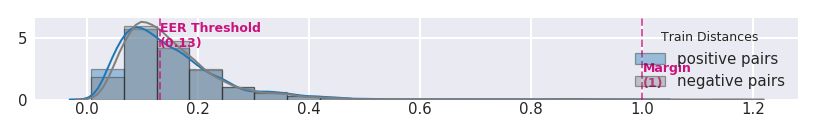


VALID: roc_auc: 0.4936, eer: 0.5184, thres: 0.1362 => acc: 0.4816, f1: 0.4815



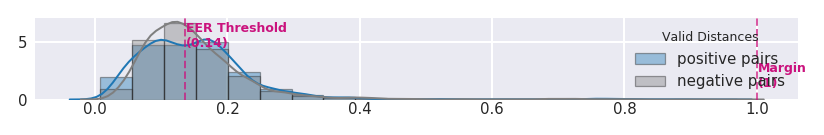

================================[   Epoch 0   ]================================
TRAIN: roc_auc: 0.6466, eer: 0.3995, thres: 0.4041 => acc: 0.6004, f1: 0.6004
val_loss: 0.227, loss: 0.249


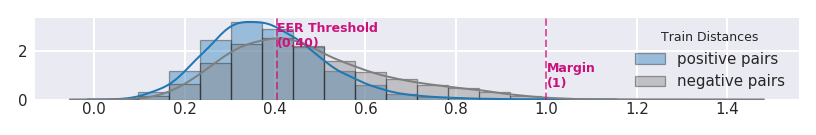


VALID: roc_auc: 0.6870, eer: 0.3672, thres: 0.4139 => acc: 0.6327, f1: 0.6326
val_loss: 0.227, loss: 0.249


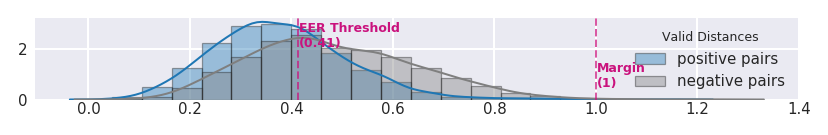

================================[   Epoch 1   ]================================
val_loss: 0.209, loss: 0.225
================================[   Epoch 2   ]================================
val_loss: 0.194, loss: 0.217
================================[   Epoch 3   ]================================
val_loss: 0.196, loss: 0.210
================================[   Epoch 4   ]================================
val_loss: 0.185, loss: 0.206
================================[   Epoch 5   ]================================
TRAIN: roc_auc: 0.7542, eer: 0.3197, thres: 0.4591 => acc: 0.6803, f1: 0.6803
val_loss: 0.183, loss: 0.202


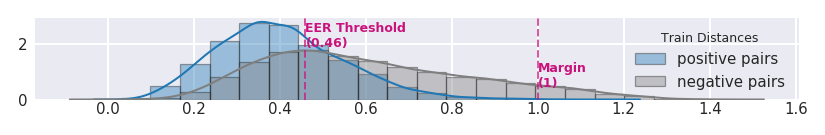


VALID: roc_auc: 0.7930, eer: 0.2976, thres: 0.4967 => acc: 0.7024, f1: 0.7024
val_loss: 0.183, loss: 0.202


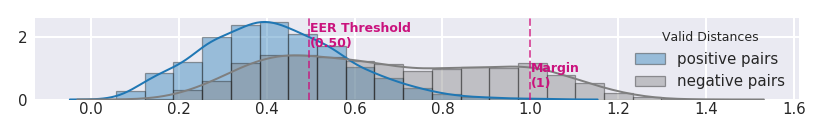

================================[   Epoch 6   ]================================
val_loss: 0.188, loss: 0.199
================================[   Epoch 7   ]================================
val_loss: 0.186, loss: 0.196
================================[   Epoch 8   ]================================
val_loss: 0.187, loss: 0.195
================================[   Epoch 9   ]================================
val_loss: 0.182, loss: 0.193
================================[   Epoch 10   ]================================
TRAIN: roc_auc: 0.7852, eer: 0.2985, thres: 0.4667 => acc: 0.7015, f1: 0.7015
val_loss: 0.178, loss: 0.191


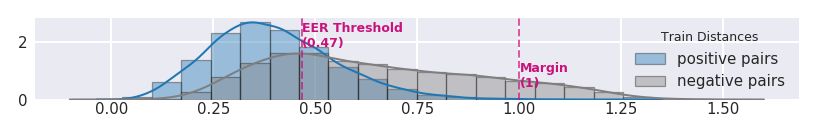


VALID: roc_auc: 0.8140, eer: 0.2749, thres: 0.5125 => acc: 0.7253, f1: 0.7253
val_loss: 0.178, loss: 0.191


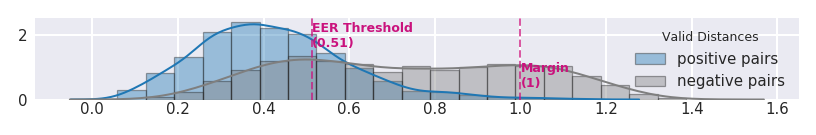

================================[   Epoch 11   ]================================
val_loss: 0.178, loss: 0.190
================================[   Epoch 12   ]================================
val_loss: 0.187, loss: 0.189
================================[   Epoch 13   ]================================
val_loss: 0.179, loss: 0.188
================================[   Epoch 14   ]================================
val_loss: 0.178, loss: 0.187
================================[   Epoch 15   ]================================
TRAIN: roc_auc: 0.7988, eer: 0.2864, thres: 0.4710 => acc: 0.7134, f1: 0.7134
val_loss: 0.179, loss: 0.186


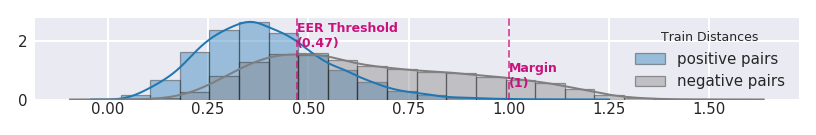


VALID: roc_auc: 0.8122, eer: 0.2729, thres: 0.5210 => acc: 0.7271, f1: 0.7271
val_loss: 0.179, loss: 0.186


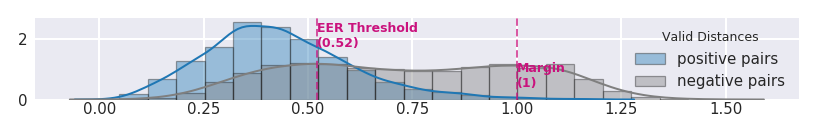

================================[   Epoch 16   ]================================
val_loss: 0.175, loss: 0.185
================================[   Epoch 17   ]================================
val_loss: 0.179, loss: 0.185
================================[   Epoch 18   ]================================
val_loss: 0.179, loss: 0.183
================================[   Epoch 19   ]================================
val_loss: 0.183, loss: 0.183
================================[   Epoch 20   ]================================
TRAIN: roc_auc: 0.8057, eer: 0.2787, thres: 0.4894 => acc: 0.7214, f1: 0.7213
val_loss: 0.184, loss: 0.182


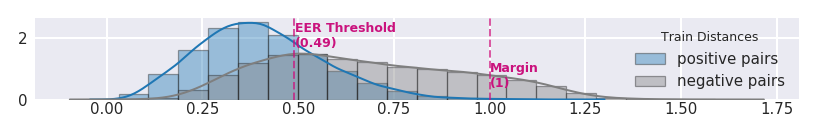


VALID: roc_auc: 0.8035, eer: 0.2787, thres: 0.5364 => acc: 0.7213, f1: 0.7213
val_loss: 0.184, loss: 0.182


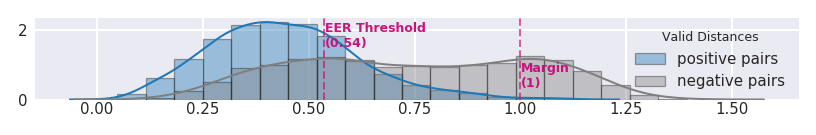

================================[   Epoch 21   ]================================
val_loss: 0.182, loss: 0.181
================================[   Epoch 22   ]================================
val_loss: 0.179, loss: 0.180
================================[   Epoch 23   ]================================
val_loss: 0.185, loss: 0.179
================================[   Epoch 24   ]================================
val_loss: 0.188, loss: 0.180
================================[   Epoch 25   ]================================
TRAIN: roc_auc: 0.8210, eer: 0.2665, thres: 0.4986 => acc: 0.7334, f1: 0.7334
val_loss: 0.183, loss: 0.178


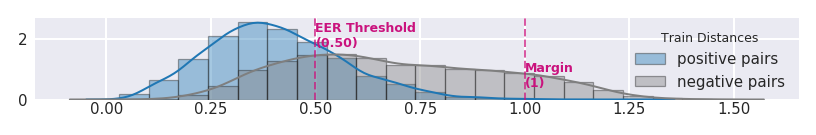


VALID: roc_auc: 0.8082, eer: 0.2761, thres: 0.5438 => acc: 0.7240, f1: 0.7240
val_loss: 0.183, loss: 0.178


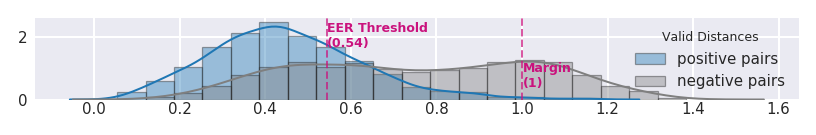

================================[   Epoch 26   ]================================
val_loss: 0.180, loss: 0.177
================================[   Epoch 27   ]================================
val_loss: 0.181, loss: 0.177
================================[   Epoch 28   ]================================
val_loss: 0.181, loss: 0.176
================================[   Epoch 29   ]================================
val_loss: 0.183, loss: 0.176
================================[   Epoch 30   ]================================
TRAIN: roc_auc: 0.8296, eer: 0.2559, thres: 0.4829 => acc: 0.7441, f1: 0.7441
val_loss: 0.175, loss: 0.176


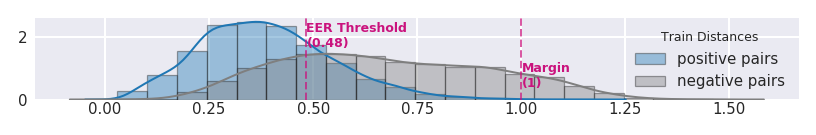


VALID: roc_auc: 0.8183, eer: 0.2672, thres: 0.5180 => acc: 0.7326, f1: 0.7326
val_loss: 0.175, loss: 0.176


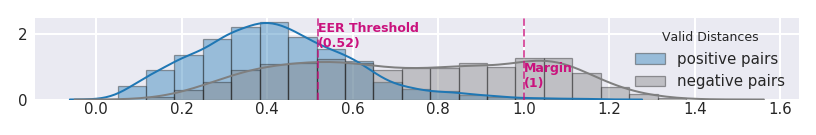

================================[   Epoch 31   ]================================
val_loss: 0.177, loss: 0.175
================================[   Epoch 32   ]================================
val_loss: 0.178, loss: 0.175
================================[   Epoch 33   ]================================
val_loss: 0.180, loss: 0.175
================================[   Epoch 34   ]================================
val_loss: 0.178, loss: 0.174
================================[   Epoch 35   ]================================
TRAIN: roc_auc: 0.8317, eer: 0.2566, thres: 0.4884 => acc: 0.7434, f1: 0.7434
val_loss: 0.176, loss: 0.174


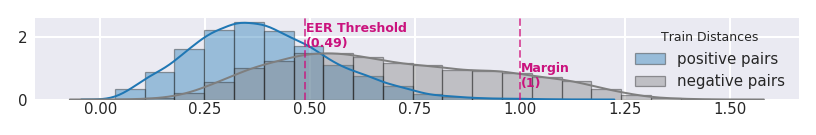


VALID: roc_auc: 0.8197, eer: 0.2690, thres: 0.5290 => acc: 0.7312, f1: 0.7311
val_loss: 0.176, loss: 0.174


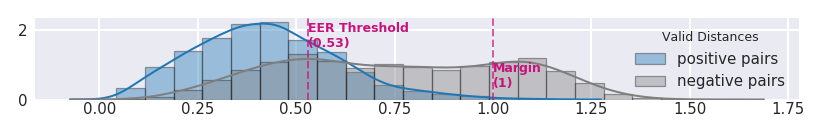

================================[   Epoch 36   ]================================
val_loss: 0.179, loss: 0.173
================================[   Epoch 37   ]================================
val_loss: 0.177, loss: 0.173
================================[   Epoch 38   ]================================
val_loss: 0.179, loss: 0.172
================================[   Epoch 39   ]================================
val_loss: 0.178, loss: 0.171
================================[   Epoch 40   ]================================
TRAIN: roc_auc: 0.8392, eer: 0.2487, thres: 0.4944 => acc: 0.7512, f1: 0.7512
val_loss: 0.180, loss: 0.171


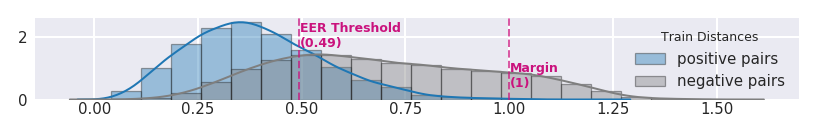


VALID: roc_auc: 0.8138, eer: 0.2722, thres: 0.5361 => acc: 0.7278, f1: 0.7278
val_loss: 0.180, loss: 0.171


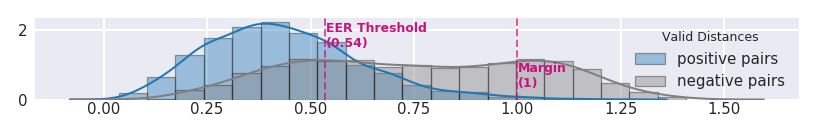

================================[   Epoch 41   ]================================
val_loss: 0.177, loss: 0.171
================================[   Epoch 42   ]================================
val_loss: 0.176, loss: 0.169
================================[   Epoch 43   ]================================
val_loss: 0.175, loss: 0.169
================================[   Epoch 44   ]================================
val_loss: 0.176, loss: 0.170
================================[   Epoch 45   ]================================
TRAIN: roc_auc: 0.8424, eer: 0.2452, thres: 0.5091 => acc: 0.7548, f1: 0.7547
val_loss: 0.179, loss: 0.169


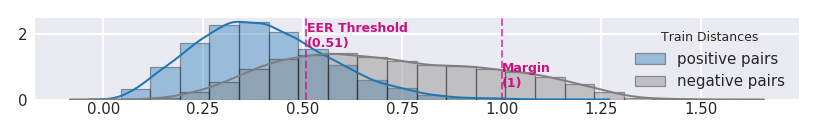


VALID: roc_auc: 0.8182, eer: 0.2679, thres: 0.5486 => acc: 0.7323, f1: 0.7322
val_loss: 0.179, loss: 0.169


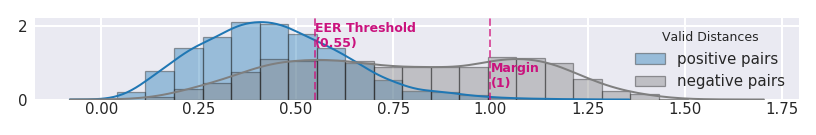

================================[   Epoch 46   ]================================
val_loss: 0.179, loss: 0.169
================================[   Epoch 47   ]================================
val_loss: 0.180, loss: 0.168
================================[   Epoch 48   ]================================
val_loss: 0.177, loss: 0.169
================================[   Epoch 49   ]================================
val_loss: 0.176, loss: 0.167
================================[   Epoch 50   ]================================
TRAIN: roc_auc: 0.8426, eer: 0.2438, thres: 0.4988 => acc: 0.7562, f1: 0.7562
val_loss: 0.177, loss: 0.167


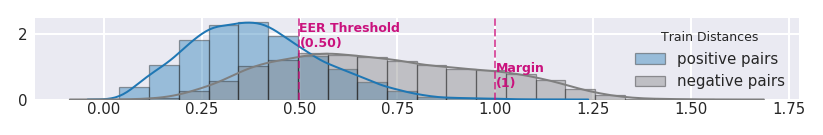


VALID: roc_auc: 0.8145, eer: 0.2753, thres: 0.5229 => acc: 0.7247, f1: 0.7247
val_loss: 0.177, loss: 0.167


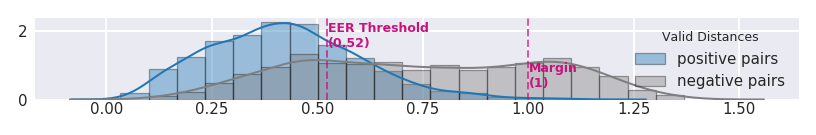

================================[   Epoch 51   ]================================
val_loss: 0.173, loss: 0.167
================================[   Epoch 52   ]================================
val_loss: 0.173, loss: 0.167
================================[   Epoch 53   ]================================
val_loss: 0.179, loss: 0.166
================================[   Epoch 54   ]================================
val_loss: 0.182, loss: 0.166
================================[   Epoch 55   ]================================
TRAIN: roc_auc: 0.8481, eer: 0.2417, thres: 0.4813 => acc: 0.7583, f1: 0.7582
val_loss: 0.177, loss: 0.166


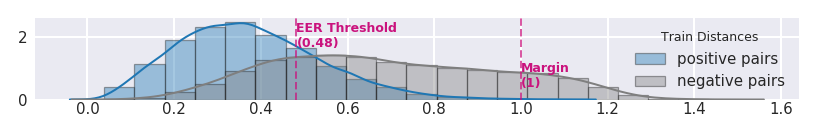


VALID: roc_auc: 0.8152, eer: 0.2668, thres: 0.5159 => acc: 0.7330, f1: 0.7329
val_loss: 0.177, loss: 0.166


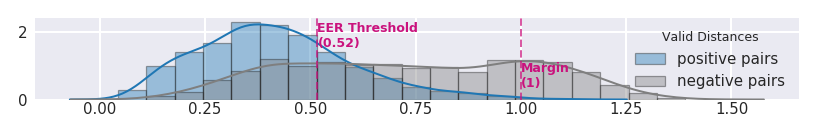

================================[   Epoch 56   ]================================
val_loss: 0.175, loss: 0.165
================================[   Epoch 57   ]================================
val_loss: 0.175, loss: 0.165
================================[   Epoch 58   ]================================
val_loss: 0.173, loss: 0.165
================================[   Epoch 59   ]================================
val_loss: 0.177, loss: 0.164
================================[   Epoch 60   ]================================
TRAIN: roc_auc: 0.8564, eer: 0.2318, thres: 0.5060 => acc: 0.7682, f1: 0.7682
val_loss: 0.176, loss: 0.164


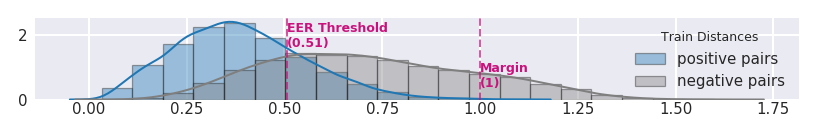


VALID: roc_auc: 0.8181, eer: 0.2693, thres: 0.5353 => acc: 0.7308, f1: 0.7308
val_loss: 0.176, loss: 0.164


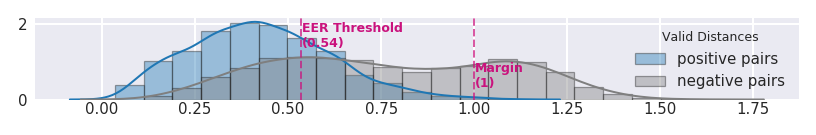

================================[   Epoch 61   ]================================
val_loss: 0.178, loss: 0.164
================================[   Epoch 62   ]================================
val_loss: 0.174, loss: 0.164
================================[   Epoch 63   ]================================
val_loss: 0.176, loss: 0.164
================================[   Epoch 64   ]================================
val_loss: 0.173, loss: 0.163
================================[   Epoch 65   ]================================
TRAIN: roc_auc: 0.8523, eer: 0.2326, thres: 0.5074 => acc: 0.7674, f1: 0.7674
val_loss: 0.176, loss: 0.162


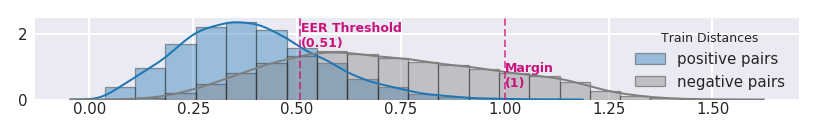


VALID: roc_auc: 0.8180, eer: 0.2754, thres: 0.5364 => acc: 0.7247, f1: 0.7247
val_loss: 0.176, loss: 0.162


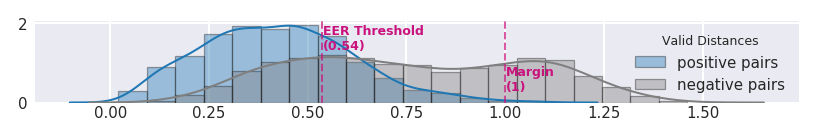

================================[   Epoch 66   ]================================
val_loss: 0.176, loss: 0.163
================================[   Epoch 67   ]================================
val_loss: 0.181, loss: 0.162
================================[   Epoch 68   ]================================
val_loss: 0.176, loss: 0.162
================================[   Epoch 69   ]================================
val_loss: 0.176, loss: 0.162
================================[   Epoch 70   ]================================
TRAIN: roc_auc: 0.8538, eer: 0.2329, thres: 0.4920 => acc: 0.7672, f1: 0.7672
val_loss: 0.175, loss: 0.161


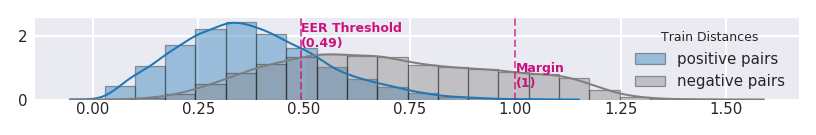


VALID: roc_auc: 0.8184, eer: 0.2654, thres: 0.5285 => acc: 0.7344, f1: 0.7344
val_loss: 0.175, loss: 0.161


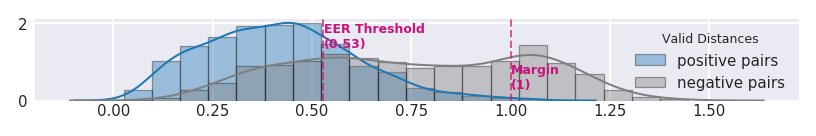

================================[   Epoch 71   ]================================
val_loss: 0.175, loss: 0.161
================================[   Epoch 72   ]================================
val_loss: 0.178, loss: 0.161
================================[   Epoch 73   ]================================
val_loss: 0.183, loss: 0.161
================================[   Epoch 74   ]================================
val_loss: 0.177, loss: 0.160
================================[   Epoch 75   ]================================
TRAIN: roc_auc: 0.8596, eer: 0.2290, thres: 0.5089 => acc: 0.7710, f1: 0.7710
val_loss: 0.177, loss: 0.161


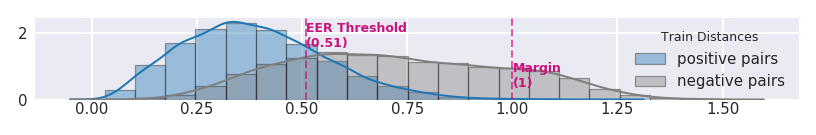


VALID: roc_auc: 0.8164, eer: 0.2718, thres: 0.5345 => acc: 0.7278, f1: 0.7276
val_loss: 0.177, loss: 0.161


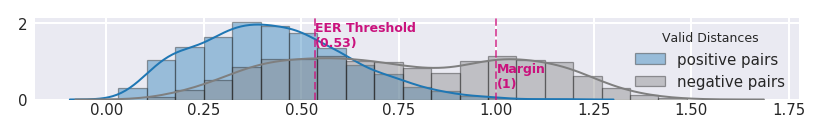

================================[   Epoch 76   ]================================
val_loss: 0.174, loss: 0.160
================================[   Epoch 77   ]================================
val_loss: 0.173, loss: 0.160
================================[   Epoch 78   ]================================
val_loss: 0.179, loss: 0.159
================================[   Epoch 79   ]================================
val_loss: 0.175, loss: 0.159
================================[ Final State ]================================
TRAIN: roc_auc: 0.8641, eer: 0.2254, thres: 0.5093 => acc: 0.7746, f1: 0.7746



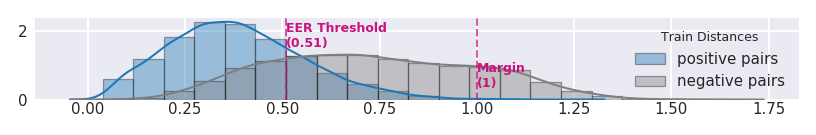


VALID: roc_auc: 0.8200, eer: 0.2729, thres: 0.5308 => acc: 0.7273, f1: 0.7272



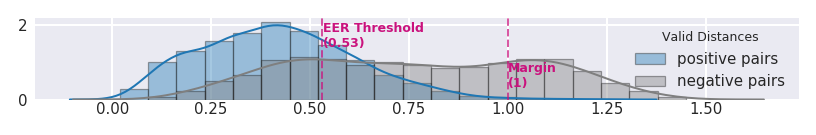

Training History:


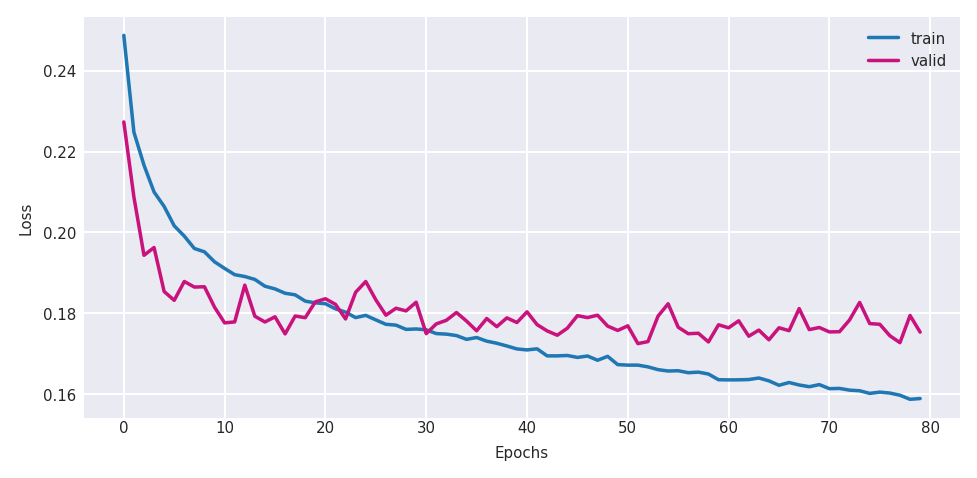

In [42]:
# Select model architecture
model, basemodel = get_model(P.model_variant, P.window_size, P.feature_cols, P.filters)

# Select Optimizer
optimizer = get_optimizer(P.optimizer, P.optimizer_lr)

# Compile
warnings.filterwarnings("ignore")
model.compile(loss=k_contrastive_loss, optimizer=optimizer)

# Train
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=P.batch_size,
    epochs=P.epochs_max,
    verbose=0,
    validation_data=(X_valid, y_valid),
    callbacks=[MetricsCallback((X_valid, y_valid, X_train, y_train), epoch_evaluate_freq=5, save_plots=True)],
)

print("Training History:")
plt = utils_plot_training_loss(history)
utils_save_plot(
    plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-epoch-trainloss.pdf"
)
plt.show()

### 4.5 Check Distances <a id='4.5'>&nbsp;</a> 

Mean distance: 0.59500
Max distance: 1.44997
Min distance: 0.01908


Histogram of Pair Distances:


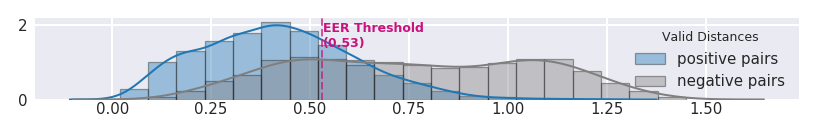

In [43]:
# Predic validation set
dists = model.predict(X_valid)

# Stats
print(f"Mean distance: {dists.mean():.5f}")
print(f"Max distance: {dists.max():.5f}")
print(f"Min distance: {dists.min():.5f}\n")

# Histrogram
print("\nHistogram of Pair Distances:")
eer_val, thres = utils_eer(y_valid, dists, True)
mask = np.where(y_valid == 1, True, False)
dist_positive = dists[mask]
dist_negative = dists[~mask]
plt = utils_plot_distance_hist(dist_positive, dist_negative, thres, "Valid")
plt.show()

### 4.6 Rebuild and train to optimal Epoch  <a id='4.6'>&nbsp;</a> 
Now, that we know the learning curve, we can rebuild the model and train it until the best Epoch.

Also, we will include the validation data to have more training data. 

**Note:** This also means, that the training metrics are not valid anymore, because we don't have any validation data left to test against...

Using Model variant fcn...
================================[ Initial State ]================================
TRAIN: roc_auc: 0.5111, eer: 0.4901, thres: 0.1108 => acc: 0.5099, f1: 0.5099



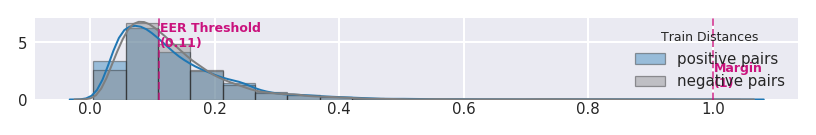

================================[   Epoch 0   ]================================
TRAIN: roc_auc: 0.6638, eer: 0.3882, thres: 0.4513 => acc: 0.6118, f1: 0.6118
loss: 0.242


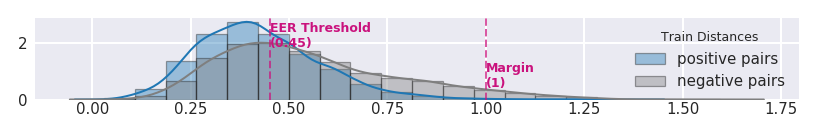

================================[   Epoch 1   ]================================
loss: 0.219
================================[   Epoch 2   ]================================
loss: 0.211
================================[   Epoch 3   ]================================
loss: 0.206
================================[   Epoch 4   ]================================
loss: 0.201
================================[   Epoch 5   ]================================
loss: 0.197
================================[   Epoch 6   ]================================
loss: 0.195
================================[   Epoch 7   ]================================
loss: 0.195
================================[   Epoch 8   ]================================
loss: 0.192
================================[   Epoch 9   ]================================
loss: 0.191
================================[   Epoch 10   ]================================
TRAIN: roc_auc: 0.7704, eer: 0.3082, thres: 0.4686 => acc: 0.6918, f1: 0.6918
loss: 0.190


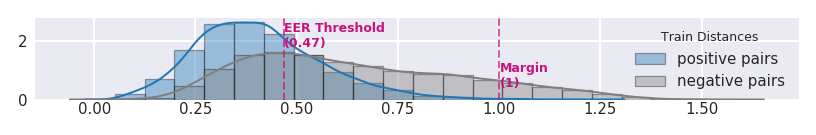

================================[   Epoch 11   ]================================
loss: 0.188
================================[   Epoch 12   ]================================
loss: 0.187
================================[   Epoch 13   ]================================
loss: 0.187
================================[   Epoch 14   ]================================
loss: 0.186
================================[   Epoch 15   ]================================
loss: 0.185
================================[   Epoch 16   ]================================
loss: 0.183
================================[   Epoch 17   ]================================
loss: 0.183
================================[   Epoch 18   ]================================
loss: 0.182
================================[   Epoch 19   ]================================
loss: 0.183
================================[   Epoch 20   ]================================
TRAIN: roc_auc: 0.7889, eer: 0.2935, thres: 0.4786 => acc: 0.7066, f1: 0.7066
loss

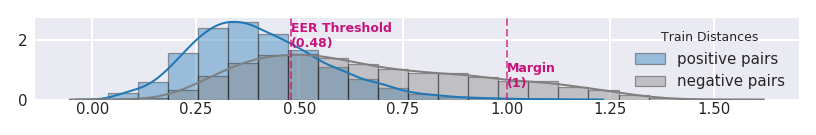

================================[   Epoch 21   ]================================
loss: 0.180
================================[   Epoch 22   ]================================
loss: 0.179
================================[   Epoch 23   ]================================
loss: 0.179
================================[   Epoch 24   ]================================
loss: 0.178
================================[   Epoch 25   ]================================
loss: 0.177
================================[   Epoch 26   ]================================
loss: 0.177
================================[   Epoch 27   ]================================
loss: 0.176
================================[   Epoch 28   ]================================
loss: 0.176
================================[   Epoch 29   ]================================
loss: 0.174
================================[   Epoch 30   ]================================
TRAIN: roc_auc: 0.8148, eer: 0.2732, thres: 0.4885 => acc: 0.7268, f1: 0.7268
loss

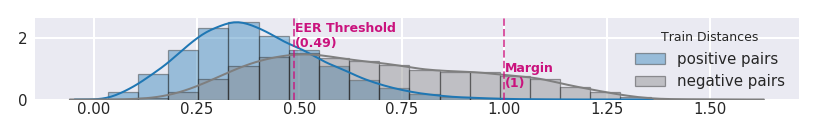

================================[   Epoch 31   ]================================
loss: 0.174
================================[   Epoch 32   ]================================
loss: 0.172
================================[   Epoch 33   ]================================
loss: 0.173
================================[   Epoch 34   ]================================
loss: 0.173
================================[   Epoch 35   ]================================
loss: 0.172
================================[   Epoch 36   ]================================
loss: 0.171
================================[   Epoch 37   ]================================
loss: 0.170
================================[   Epoch 38   ]================================
loss: 0.170
================================[   Epoch 39   ]================================
loss: 0.170
================================[ Final State ]================================
TRAIN: roc_auc: 0.8239, eer: 0.2632, thres: 0.4894 => acc: 0.7370, f1: 0.7370



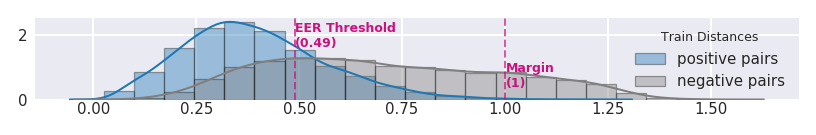

In [44]:
# Concat train & valid data
X_train_valid = [[], []]
X_train_valid[0] = np.vstack([X_train[0], X_valid[0]])
X_train_valid[1] = np.vstack([X_train[1], X_valid[1]])
y_train_valid = np.hstack([y_train, y_valid])

# Select model architecture
model, basemodel = get_model(P.model_variant, P.window_size, P.feature_cols, P.filters)

# Select Optimizer
optimizer = get_optimizer(P.optimizer, P.optimizer_lr)
    
# Compile
model.compile(loss=k_contrastive_loss, optimizer=optimizer)

# Train
history = model.fit(
    x=X_train_valid,
    y=y_train_valid,
    batch_size=P.batch_size,
    epochs=P.epochs_best,
    verbose=0,
    callbacks=[MetricsCallback((None, None, X_train, y_train), epoch_evaluate_freq=10, save_plots=False)],
)

### 4.7 Cache model <a id='4.7'>&nbsp;</a> 

In [45]:
model.save(str((OUTPUT_PATH / f"{P.name}_model.h5").resolve()))

In [46]:
# Clean Memory
%reset_selective -f df_
%reset_selective -f X_
%reset_selective -f y_

## 5. Visualize Deep Features <a id='5'>&nbsp;</a> 

### 5.1 Load cached Data <a id='5.1'>&nbsp;</a> 

In [47]:
df_siamese_valid = pd.read_msgpack(OUTPUT_PATH / "NAIVE_df_siamese_valid.msg")
df_siamese_train = pd.read_msgpack(OUTPUT_PATH / "NAIVE_df_siamese_train.msg")

df_ocsvm_train_valid = pd.read_msgpack(OUTPUT_PATH / "NAIVE_df_ocsvm_train_valid.msg")

### 5.2 Extract CNN from Siamese Model <a id='5.2'>&nbsp;</a> 
I do this by redirecting inputs and outputs.

However, the network still needs a pair as input (I wasn't able to change this). This slows down a little bit the prediction (as the input is predicted twice), but doesn't change the results.

In [48]:
def load_deep_feature_model(model_path):
    # Copy of function from above. It's just more convenient for partially 
    # executing the notebook.
    def k_contrastive_loss(y_true, dist):
        """Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        """
        margin = P.margin
        return K.mean(
            y_true * K.square(dist)
            + (1 - y_true) * K.square(K.maximum(margin - dist, 0))
        )
    
    # Load Trained Siamese Network
    model = load_model(
        str(model_path.resolve()),
        custom_objects={"k_contrastive_loss": k_contrastive_loss},
    )

    # Extract one of the child networks
    deep_feature_model = Model(
        inputs=model.get_input_at(0),  # get_layer("left_inputs").input,
        outputs=model.get_layer("basemodel").get_output_at(1),
    )
    
    return deep_feature_model

In [49]:
P.name="VALID-FCN-std"
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")
deep_feature_model.summary()

/home/u/uhengart/ezzeldi/.local/lib/python3.6/site-packages/keras/engine/saving.py:251: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if weight_names:


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
left_inputs (InputLayer)     (None, 125, 3)            0         
_________________________________________________________________
basemodel (Model)            (None, 32)                18848     
Total params: 18,848
Trainable params: 18,592
Non-trainable params: 256
_________________________________________________________________


### 5.3 Test Generation of Deep Features <a id='5.3'>&nbsp;</a> 

In [50]:
def prep_X_y_single(df):
    X = np.stack(list(df["X"].values))
    y = df["label"].values
    return X, y

In [51]:
def transform_to_sample_by_subject(df):
    sample_by_subject = []
    df["label"] = 1
    for subj in df["subject"].unique():
        df_subj = df[df["subject"] == subj]
        X_sub, y_sub = prep_X_y_single(df_subj)
        sample_by_subject.append((X_sub, y_sub, subj))
    return sample_by_subject

#### Select subset (for plotting) and transform features

In [52]:
# Concat Valid & Train (both were used for last Training)
df_train_temp = pd.concat([df_siamese_valid, df_siamese_train])
df_test_temp = df_ocsvm_train_valid

# Select data from 20 subjects of the TRAINING SET
random.seed(SEED)
ten_subjects = random.sample(df_train_temp["subject"].unique().tolist(), 20)
df_train_temp = df_train_temp[df_train_temp["subject"].isin(ten_subjects)].copy()
df_train_temp = df_train_temp.groupby("subject").apply(lambda x: x.sample(n=300, random_state=SEED))  # Plot only subset of samples

# Select data from 10 subjects of the TEST SET (not included in training)
random.seed(SEED)
ten_subjects = random.sample(df_test_temp["subject"].unique().tolist(), 10)
df_test_temp = df_test_temp[df_ocsvm_train_valid["subject"].isin(ten_subjects)].copy()
df_test_temp = df_test_temp.groupby("subject").apply(lambda x: x.sample(n=300, random_state=SEED))  # Plot only subset of samples

# Transform Samples
samples_train = transform_to_sample_by_subject(df_train_temp)
samples_test = transform_to_sample_by_subject(df_test_temp)

print(f"First subject: {samples_train[0][2]}")
print(f"y shape: {samples_train[0][1].shape}")
print(f"X shape: {samples_train[0][0].shape}")

First subject: 218719
y shape: (300,)
X shape: (300, 125, 3)


#### Predict Deep Features

In [53]:
deep_features_train = None
for X, y, subj in samples_train:  
    if P.model_variant == "2d":
        X = X.reshape((*X.shape, 1))
    pred = deep_feature_model.predict([X, X])
    df_features = pd.DataFrame(pred)
    df_features["subject"] = subj
    deep_features_train = pd.concat([deep_features_train, df_features])
        
deep_features_test = None
for X, y, subj in samples_test:  
    if P.model_variant == "2d":
        X = X.reshape((*X.shape, 1))
    pred = deep_feature_model.predict([X, X])
    df_features = pd.DataFrame(pred)
    df_features["subject"] = subj
    deep_features_test = pd.concat([deep_features_test, df_features])
        
display(deep_features_train.head(3))
display(deep_features_test.head(3))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,subject
0,0.645321,0.317353,0.460029,0.651953,0.091580,0.591086,0.725667,0.357435,0.354993,0.657674,0.430652,0.380889,0.581002,0.810984,0.631886,0.273999,0.449249,0.542322,0.493655,0.760513,0.185120,0.704677,0.620907,0.719224,0.614518,0.575323,0.409394,0.698836,0.575631,0.188898,0.800155,0.553475,218719
1,0.658935,0.314548,0.486458,0.647981,0.100213,0.565301,0.687030,0.431131,0.374241,0.711124,0.435052,0.455838,0.567156,0.819698,0.613606,0.301396,0.480908,0.704875,0.488910,0.718346,0.114757,0.652973,0.593496,0.694435,0.588847,0.570193,0.500140,0.699814,0.554604,0.124590,0.842130,0.576893,218719
2,0.684956,0.301854,0.474565,0.660288,0.098814,0.560598,0.679624,0.444688,0.381861,0.677940,0.438481,0.457032,0.545199,0.824173,0.627792,0.302134,0.458119,0.707976,0.491464,0.730954,0.122500,0.605475,0.616658,0.694870,0.602805,0.570036,0.495313,0.719014,0.550974,0.133887,0.843311,0.562213,218719


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,subject
0,0.587155,0.320225,0.469055,0.656882,0.089258,0.629509,0.729709,0.356583,0.342872,0.909981,0.366927,0.304754,0.533604,0.909570,0.687991,0.284840,0.442940,0.711004,0.446039,0.823466,0.091084,0.810341,0.695027,0.872455,0.610840,0.617560,0.342963,0.704766,0.615910,0.045481,0.949542,0.495683,186676
1,0.483519,0.441812,0.598271,0.461008,0.063916,0.650244,0.552050,0.543459,0.552248,0.832088,0.379347,0.139151,0.603273,0.832732,0.673777,0.393013,0.420208,0.011372,0.437348,0.738101,0.114031,0.510603,0.792397,0.887422,0.559536,0.657631,0.166088,0.628904,0.710015,0.027960,0.952040,0.327450,186676
2,0.575413,0.335925,0.480927,0.637682,0.084152,0.619591,0.707185,0.370043,0.356798,0.862525,0.389210,0.319229,0.546419,0.874250,0.674866,0.299732,0.453482,0.526576,0.452024,0.800217,0.116719,0.717273,0.681225,0.829654,0.603871,0.616404,0.347639,0.688834,0.605187,0.063125,0.928203,0.492861,186676


### 5.4 Visualize in 2D using PCA <a id='5.4'>&nbsp;</a> 

In [54]:
def plot_pca(df):
    # PCA
    pca = PCA(n_components=2)
    deep_transformed = pca.fit_transform(df.drop(columns=["subject"]).values)

    # Create df with data needed for chart only
    df_viz = df.copy()
    df_viz["PCA0"] = deep_transformed[:, 0]
    df_viz["PCA1"] = deep_transformed[:, 1]
    df_viz.drop(
        columns=[c for c in df_viz.columns if c not in ["PCA0", "PCA1", "subject"]]
    )

    # Generate color index for every subject
    df_viz["Subject"] = pd.Categorical(df_viz["subject"])
    df_viz["colors"] = df_viz["Subject"].cat.codes

    if len(df_viz["Subject"].unique()) <= 10:
        pal = sns.color_palette("tab10")
    else:
        pal = sns.color_palette("tab20")
        
    # Actual plot
    fig = plt.figure(figsize=(5.473 / 1.5, 5.473 / 2), dpi=180)
    sns.scatterplot(
        x="PCA0",
        y="PCA1",
        data=df_viz,
        hue="Subject",
        legend="full",
        palette=pal,
        s=2,
        linewidth=0,
        alpha=0.6,
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize=5)
    fig.tight_layout()
    return plt

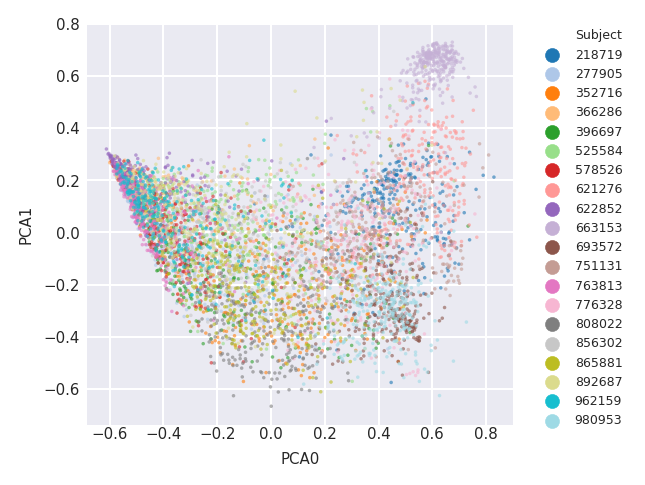

In [55]:
plot_pca(deep_features_train)
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-pca-train.pdf")

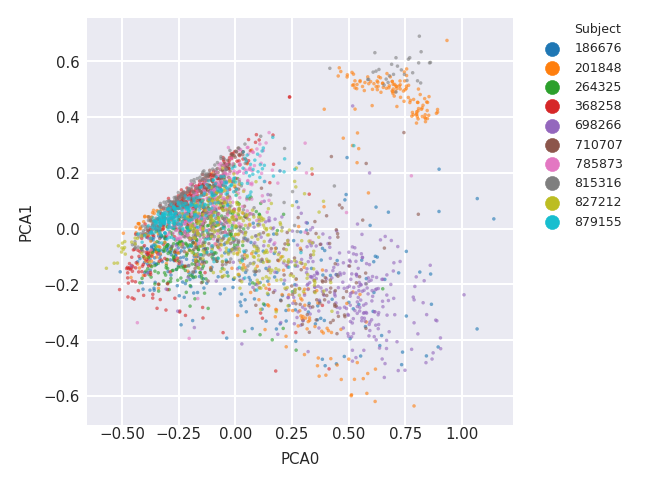

In [56]:
plot_pca(deep_features_test)
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-pca-test.pdf")

In [57]:
### Cleanup memory
%reset_selective -f df_
%reset_selective -f X_
%reset_selective -f y_
%reset_selective -f pca

## 6. OCSVM <a id='6'>&nbsp;</a> 

### 6.1 Load cached Data <a id='6.1'>&nbsp;</a> 

In [58]:
df_ocsvm_train_valid = pd.read_msgpack(OUTPUT_PATH / "NAIVE_df_ocsvm_train_valid.msg")
df_ocsvm_train_valid.head()

,X,subject,session,task_type
0,"((-8.607810569636623, 0.9955167241816556, -1.9...",186676,186676_session_1,4
1,"((-0.3209477333333335, 3.128859958333334, 9.44...",186676,186676_session_1,4
2,"((-2.057314, 4.621461133928572, 7.006203626785...",186676,186676_session_1,4
3,"((0.534176783756579, 6.0081232518346415, 8.295...",186676,186676_session_1,4
4,"((-1.53348510239776, 5.71207867121504, 8.14309...",186676,186676_session_1,4


### 6.2 Load trained Siamese Model <a id='6.2'>&nbsp;</a> 

**Helper methods to load model:**

In [59]:
def load_deep_feature_model(model_path):
    warnings.filterwarnings("ignore")  # Silence depr. warnings

    # Copy of function from above. It's just more convenient for partially executing the notebook.
    def k_contrastive_loss(y_true, dist):
        """Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        """
        margin = P.margin
        return K.mean(
            y_true * K.square(dist)
            + (1 - y_true) * K.square(K.maximum(margin - dist, 0))
        )

    # Load Trained Siamese Network
    model = load_model(
        str(model_path.resolve()),
        custom_objects={"k_contrastive_loss": k_contrastive_loss},
    )

    # Extract one of the child networks
    deep_feature_model = Model(
        inputs=model.get_input_at(0),  # get_layer("left_inputs").input,
        outputs=model.get_layer("basemodel").get_output_at(1),
    )

    return deep_feature_model

**Sanity Check:**

### 6.3 Search for Parameters <a id='6.3'>&nbsp;</a> 

### 6.4 Inspect Search Results <a id='6.4'>&nbsp;</a> 
**Raw Results & Stats:**

**Plot parameters of top n of 30 results for every Owner:**

In [60]:
#utils_plot_randomsearch_results(df_results, 1)
#utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-parameters.pdf")

## 7. Testing <a id='7'>&nbsp;</a> 

### 7.1 Load cached Data <a id='7.1'>&nbsp;</a> 
During testing, a split with different users than used for hyperparameter optimization is used:

In [61]:
df_ocsvm_train_test = pd.read_msgpack(OUTPUT_PATH / "NAIVE_df_ocsvm_train_test.msg")

### 7.2 Evaluate Authentication Performance <a id='7.2'>&nbsp;</a> 
- Using Testing Split, Scenario Cross Validation, and multiple runs to lower impact of random session/sample selection.

In [62]:
# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with cv scores
for i in tqdm(range(5), desc="Run", leave=False):  # Run whole test 5 times
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_ocsvm_train_test,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            seed=SEED,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            deep_model=deep_feature_model,
            model_variant=P.model_variant,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_ocsvm_train_test["subject"].nunique(),
        leave=False,
    ):

        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values

        train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = OneClassSVM(kernel="rbf", nu=P.ocsvm_nu, gamma=P.ocsvm_gamma)

        warnings.filterwarnings("ignore")
        scores = cross_validate(
            model,
            X,
            y,
            cv=train_test_cv,
            scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
            n_jobs=CORES,
            verbose=0,
            return_train_score=True,
        )
        df_score = pd.DataFrame(scores)
        df_score["owner"] = owner
        df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
        df_score["test_eer"] = df_score["test_eer"].abs()
        df_results = pd.concat([df_results, df_score], axis=0)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_test_results.csv", index=False)
df_results.head()

,fit_time,score_time,test_eer,train_eer,test_accuracy,train_accuracy,owner
0,0.001414,0.002378,0.355556,1.818989e-12,0.654762,0.825397,872895
1,0.001464,0.002620,0.282609,1.818989e-12,0.738095,0.825397,872895
2,0.001410,0.002502,0.276596,1.818989e-12,0.750000,0.825397,872895
3,0.001957,0.002933,0.408163,1.818989e-12,0.607143,0.825397,872895
4,0.001416,0.002320,0.382979,1.818989e-12,0.630952,0.825397,872895


**Load Results from "EER & Accuracy" evaluation & prepare for plotting:**

In [63]:
df_results.keys()

Index(['fit_time', 'score_time', 'test_eer', 'train_eer', 'test_accuracy', 'train_accuracy', 'owner'], dtype='object')

In [64]:
#df_plot.keys()

In [65]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_test_results.csv")
df_plot = df_results.rename(
    columns={"test_accuracy": "Test Accuracy", "test_eer": "Test EER", "owner": "Owner"}
).astype({"Owner": str})

**Plot Distribution of Accuracy per subject:**

Overall mean: 0.6910


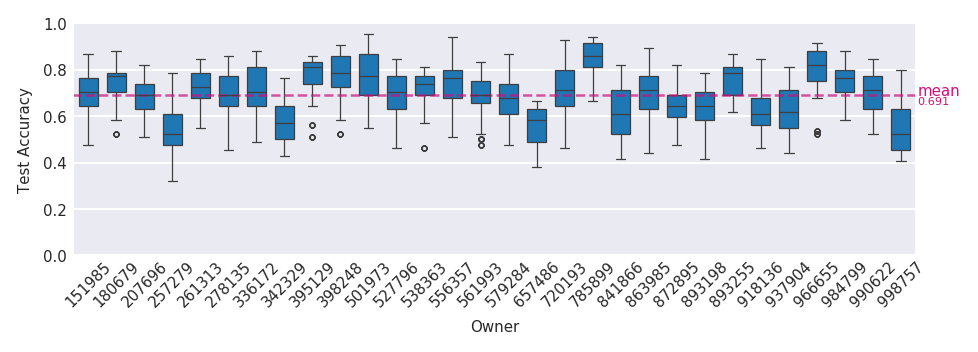

In [66]:
fig = utils_plot_acc_eer_dist(df_plot, "Test Accuracy")
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-acc.pdf")

**Plot Distribution of EER per subject:**

Overall mean: 0.3336


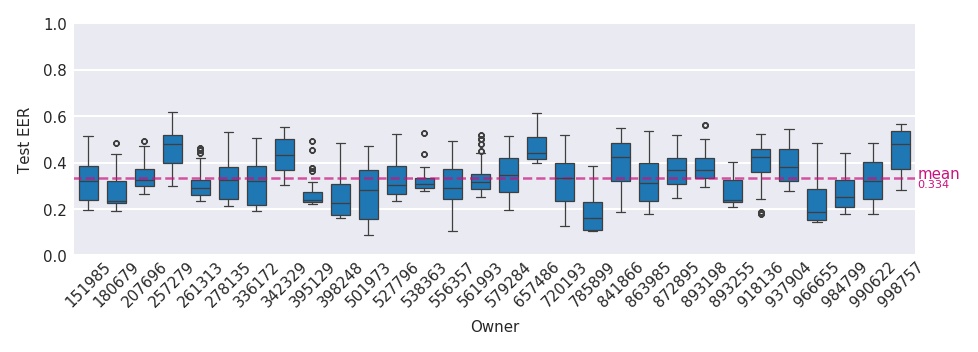

In [67]:
fig = utils_plot_acc_eer_dist(df_plot, "Test EER")
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-eer.pdf")

3amo 
run author ocsvm deep and no deep (without pyod y transition) 

run pca and mcd no deep 

play with contamination for vae to find the best result in vae std no deep (score to beat is knn at 34.91)

In [80]:

# Load Siamese CNN Model
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.loci import LOCI
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.sos import SOS
from pyod.models.lscp import LSCP
from pyod.models.cof import COF
from pyod.models.sod import SOD
from pyod.models.xgbod import XGBOD
from pyod.models.vae import VAE
from pyod.models.auto_encoder import AutoEncoder
from keras import losses
from keras import activations
cont=.2 # for FCN 
# cont = .1 # for naive 

def trans_for_pyod (y) : 
    for i in range(len(y)): 
        if y[i] == -1: 
            y[i]=1
        elif y[i] == 1:
            y[i] = 0 
    return y 

'''
ABOD(contamination=cont,), 
CBLOF(contamination=cont,), 
FeatureBagging(contamination=cont,), 
HBOS(contamination=cont,), 
IForest(contamination=cont,), 
KNN(contamination=cont,), 
LOF(contamination=cont,), 
LOCI(contamination=cont,), 
MCD(contamination=cont,), 
OCSVM(contamination=cont,), 
PCA(contamination=cont,), 
'''#gamma > 1 and capacity != 0 for beta-VAE

cont=.2 
r_cont=.137
modelss = [
    OneClassSVM(kernel="rbf", nu=P.ocsvm_nu, gamma=P.ocsvm_gamma), 
    
    #VAE(), 
    VAE([16,1],[1,16],contamination=cont,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,hidden_activation=activations.tanh,batch_size=32,output_activation=activations.softmax,optimizer='sgd',loss=losses.mse),
    #VAE([16,1],[1,16],contamination=r_cont,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,hidden_activation=activations.tanh,batch_size=32,output_activation=activations.softmax,optimizer='sgd',loss=losses.mse),
    
    KNN(contamination=cont,), 
    #KNN(contamination=r_cont,), 
    
    
    ABOD(contamination=cont,), 
    #ABOD(contamination=r_cont,), 
    
    LOF(contamination=cont,), 
    #LOF(contamination=r_cont,), 

    OCSVM(contamination=cont,), 
    #OCSVM(contamination=r_cont,), 
    

]
mooo_desc = [
    'authors ocsvm', 
    #'VAE()',
    "[16,1],[1,16],contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,", 
    #"[16,1],[1,16],contamination=.137,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,", 
     "knn_cont=.2",
    #"knn_cont=.137",
    "abod_cont=.2",
    #"abod_cont=.137",
    "lof cont=.2",
    #"lof cont=.137",
    "ocsvm_cont=.2",
    #"ocsvm_cont=.137",
]


modelss= [  
VAE([16,1],[1,16],contamination=.28,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,hidden_activation=activations.tanh,batch_size=32,output_activation=activations.softmax,optimizer='sgd',loss=losses.mse),
#PCA(contamination=.1,)
]
mooo_desc = [
    "[16,1],[1,16],contamination=.28,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,",
 #"PCA(contamination=.2,) ",
]

k=0 
for mooo in modelss: 
    try: 
        df_results=pd.read_csv(OUTPUT_PATH / f"{mooo_desc[k]}5_test_results.csv")
        k=k+1
        continue
    except:
        print(mooo_desc[k])

        df_results = None  # Will be filled with cv scores
        for i in tqdm(range(5), desc="Run", leave=False):  # Run whole test 5 times
            for df_cv_scenarios, owner, impostors in tqdm(
                utils_generate_cv_scenarios(
                    df_ocsvm_train_test,
                    samples_per_subject_train=P.samples_per_subject_train,
                    samples_per_subject_test=P.samples_per_subject_test,
                    seed=SEED,
                    scaler=P.scaler,
                    scaler_global=P.scaler_global,
                    scaler_scope=P.scaler_scope,
                    deep_model=deep_feature_model,
                    model_variant=P.model_variant,
                    feature_cols=P.feature_cols,
                ),
                desc="Owner",
                total=df_ocsvm_train_test["subject"].nunique(),
                leave=False,
            ):

                X = np.array(df_cv_scenarios["X"].values.tolist())
                y = df_cv_scenarios["label"].values
                y = trans_for_pyod(y)

                train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)


                model = mooo #VAE([16,1],[1,16],output_activation=activations.softmax,optimizer='sgd',loss=losses.mse,l2_regularizer=.5,hidden_activation=activations.tanh,gamma=1.5,dropout_rate=.25,epochs=400,contamination=.1,capacity=1,batch_size=32)

                warnings.filterwarnings("ignore")
                scores = cross_validate(
                    model,
                    X,
                    y,
                    cv=train_test_cv,
                    scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
                    n_jobs=CORES,
                    verbose=1,
                    return_train_score=True,
                )
                df_score = pd.DataFrame(scores)
                df_score["owner"] = owner
                df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
                df_score["test_eer"] = df_score["test_eer"].abs()
                df_results = pd.concat([df_results, df_score], axis=0)

        df_results.to_csv(OUTPUT_PATH / f"{mooo_desc[k]}5_test_results.csv", index=False)
        df_results.head()
        k=k+1

[16,1],[1,16],contamination=.28,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   18.6s remaining:    8.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   18.9s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    6.5s remaining:    2.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    6.2s remaining:    2.8s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.0s remaining:    1.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.0s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.0s remaining:    1.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.0s remaining:    1.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.3s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.3s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.4s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.4s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.5s remaining:    1.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.6s remaining:    1.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.8s remaining:    1.7s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.9s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.7s remaining:    2.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.9s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    9.7s remaining:    4.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   17.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   14.6s remaining:    6.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   21.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   16.0s remaining:    7.2s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   16.0s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    8.4s remaining:    3.8s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    8.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    6.6s remaining:    3.0s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.9s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    6.0s remaining:    2.7s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.1s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.0s remaining:    1.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    5.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.0s remaining:    1.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.2s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.4s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.3s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.4s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.5s remaining:    1.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.5s remaining:    1.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.7s remaining:    1.7s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.9s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.8s remaining:    1.7s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.6s remaining:    2.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    9.9s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    9.0s remaining:    4.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   18.1s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   12.6s remaining:    5.7s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   22.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   10.5s remaining:    4.7s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   10.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.8s remaining:    3.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    8.0s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    6.1s remaining:    2.8s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    2.9s remaining:    1.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.0s remaining:    1.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.1s remaining:    1.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.2s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.4s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.5s remaining:    1.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.4s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.6s remaining:    1.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.7s remaining:    1.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.7s remaining:    1.7s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.2s remaining:    1.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   10.4s remaining:    4.7s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   15.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   11.9s remaining:    5.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   20.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   17.4s remaining:    7.8s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   17.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    9.7s remaining:    4.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    9.9s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    6.3s remaining:    2.8s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    6.4s remaining:    2.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.0s remaining:    1.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.1s remaining:    1.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.1s remaining:    1.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.4s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.4s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.4s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.6s remaining:    1.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.5s remaining:    1.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.7s remaining:    1.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.7s remaining:    2.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    5.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    6.3s remaining:    2.8s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   10.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    8.1s remaining:    3.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   18.9s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   13.0s remaining:    5.8s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   20.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   14.4s remaining:    6.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   14.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    8.5s remaining:    3.8s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    8.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    6.3s remaining:    2.8s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    6.1s remaining:    2.7s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.0s remaining:    1.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.0s remaining:    1.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.6s remaining:    1.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.4s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.4s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.4s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.6s remaining:    1.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.0s remaining:    1.8s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.7s remaining:    1.7s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    6.1s remaining:    2.7s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.5s remaining:    3.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   11.1s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   13.0s remaining:    5.8s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   21.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.6s remaining:    3.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   15.9s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   11.6s remaining:    5.2s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   11.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.3s remaining:    3.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    6.5s remaining:    2.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.2s remaining:    1.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.1s remaining:    1.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    5.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.2s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.3s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.3s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.4s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.5s remaining:    1.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.6s remaining:    1.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.9s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.1s remaining:    1.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.3s remaining:    1.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.0s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    6.0s remaining:    2.7s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   11.9s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    9.1s remaining:    4.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   12.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   13.6s remaining:    6.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   19.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   14.3s remaining:    6.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   14.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    9.0s remaining:    4.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   10.0s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    6.5s remaining:    2.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    6.1s remaining:    2.7s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.0s remaining:    1.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.2s remaining:    1.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.2s remaining:    1.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.4s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.4s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.4s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.6s remaining:    1.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.9s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.6s remaining:    1.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.1s remaining:    1.8s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    5.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.2s remaining:    2.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    6.3s remaining:    2.8s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   12.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    9.7s remaining:    4.4s
[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    6.1s remaining:    2.7s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.0s remaining:    1.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.2s remaining:    1.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.3s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.4s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.5s remaining:    1.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.4s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.4s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.7s remaining:    1.7s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.2s remaining:    1.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    5.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.7s remaining:    2.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.9s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    8.3s remaining:    3.7s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   15.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   16.3s remaining:    7.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   16.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   13.5s remaining:    6.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   18.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    9.5s remaining:    4.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    9.9s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    6.6s remaining:    3.0s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    6.3s remaining:    2.8s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.2s remaining:    1.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.0s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.1s remaining:    1.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.0s remaining:    1.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.4s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.4s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.4s remaining:    1.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.5s remaining:    1.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    3.6s remaining:    1.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.6s remaining:    2.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    5.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.2s remaining:    1.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.2s remaining:    3.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    8.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.7s remaining:    3.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   17.0s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   14.1s remaining:    6.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   18.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.3s remaining:    3.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   14.6s finished


In [ ]:
P.ocsvm_nu

In [ ]:
P.ocsvm_gamma

In [79]:
# Load Siamese CNN Model
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.loci import LOCI
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.sos import SOS
from pyod.models.lscp import LSCP
from pyod.models.cof import COF
from pyod.models.sod import SOD
from pyod.models.xgbod import XGBOD
from pyod.models.vae import VAE
from pyod.models.auto_encoder import AutoEncoder
from keras import losses
from keras import activations
cont=.2 # for FCN 
# cont = .1 # for naive 


'''
ABOD(contamination=cont,), 
CBLOF(contamination=cont,), 
FeatureBagging(contamination=cont,), 
HBOS(contamination=cont,), 
IForest(contamination=cont,), 
KNN(contamination=cont,), 
LOF(contamination=cont,), 
LOCI(contamination=cont,), 
MCD(contamination=cont,), 
OCSVM(contamination=cont,), 
PCA(contamination=cont,), 
'''#gamma > 1 and capacity != 0 for beta-VAE

cont=.3 
modelss = [
    KNN(contamination=cont,),  
    ABOD(contamination=cont,), 
    LOF(contamination=cont,), 
    OCSVM(contamination=cont,), 
]
mooo_desc = [
    "knn_cont=.3",
    "abod_cont=.3",
    "lof cont=.3",
    "ocsvm_cont=.3",
]


cont=.2 
r_cont=.137
modelss = [
    OneClassSVM(kernel="rbf", nu=P.ocsvm_nu, gamma=P.ocsvm_gamma), 
    
    #VAE(), 
    VAE([16,1],[1,16],contamination=cont,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,hidden_activation=activations.tanh,batch_size=32,output_activation=activations.softmax,optimizer='sgd',loss=losses.mse),
    #VAE([16,1],[1,16],contamination=r_cont,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,hidden_activation=activations.tanh,batch_size=32,output_activation=activations.softmax,optimizer='sgd',loss=losses.mse),
    
    KNN(contamination=cont,), 
    #KNN(contamination=r_cont,), 
    
    
    ABOD(contamination=cont,), 
    #ABOD(contamination=r_cont,), 
    
    LOF(contamination=cont,), 
    #LOF(contamination=r_cont,), 

    OCSVM(contamination=cont,), 
    #OCSVM(contamination=r_cont,), 
    

]
mooo_desc = [
    'authors ocsvm', 
    #'VAE()',
    "[16,1],[1,16],contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,", 
    #"[16,1],[1,16],contamination=.137,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,", 
     "knn_cont=.2",
    #"knn_cont=.137",
    "abod_cont=.2",
    #"abod_cont=.137",
    "lof cont=.2",
    #"lof cont=.137",
    "ocsvm_cont=.2",
    #"ocsvm_cont=.137",
]
#tuned

modelss= [  
VAE([16,1],[1,16],contamination=.28,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,hidden_activation=activations.tanh,batch_size=32,output_activation=activations.softmax,optimizer='sgd',loss=losses.mse),
PCA(contamination=.1,)
]
mooo_desc = [
    "[16,1],[1,16],contamination=.28,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,",
    "PCA(contamination=.1,)"
]
k=0 
for mooo in modelss: 
    try: 
        df_results=pd.read_csv(OUTPUT_PATH / f"{mooo_desc[k]}5_nodeep_test_results.csv")
        k=k+1
        continue
    except:
        print(mooo_desc[k])

        df_results = None  # Will be filled with cv scores
        for i in tqdm(range(5), desc="Run", leave=False):  # Run whole test 5 times
            for df_cv_scenarios, owner, impostors in tqdm(
                utils_generate_cv_scenarios(
                    df_ocsvm_train_test,
                    samples_per_subject_train=P.samples_per_subject_train,
                    samples_per_subject_test=P.samples_per_subject_test,
                    seed=SEED,
                    scaler=P.scaler,
                    scaler_global=P.scaler_global,
                    scaler_scope=P.scaler_scope,
                    #deep_model=deep_feature_model,   NODEEP_NODEEP_NODEEP_NODEEP_
                    #model_variant=P.model_variant,   NODEEP_NODEEP_NODEEP_NODEEP_
                    feature_cols=P.feature_cols,
                ),
                desc="Owner",
                total=df_ocsvm_train_test["subject"].nunique(),
                leave=False,
            ):

                X = np.array(df_cv_scenarios["X"].values.tolist())
                y = df_cv_scenarios["label"].values
                X = X.reshape(X.shape[-3], -1)  # flatten windows  NODEEP_NODEEP_NODEEP_NODEEP_
                y = trans_for_pyod(y)
                if mooo_desc[k] == 'authors ocsvm': 
                    print("not pyod")
                    y = df_cv_scenarios["label"].values

                train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)


                model = mooo 

                warnings.filterwarnings("ignore")
                scores = cross_validate(
                    model,
                    X,
                    y,
                    cv=train_test_cv,
                    scoring={"eer": utils_eer_scorer, "accuracy": "accuracy", "f1":"f1"},
                    n_jobs=CORES,
                    verbose=1,
                    return_train_score=True,
                )

               
                df_score = pd.DataFrame(scores)
                df_score["owner"] = owner
                df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
                df_score["test_eer"] = df_score["test_eer"].abs()
                df_results = pd.concat([df_results, df_score], axis=0)

        df_results.to_csv(OUTPUT_PATH / f"{mooo_desc[k]}5_nodeep_test_results.csv", index=False)
        df_results.head()
        k=k+1

[16,1],[1,16],contamination=.28,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   19.9s remaining:    9.0s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   20.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.6s remaining:    3.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.3s remaining:    3.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.1s remaining:    1.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.3s remaining:    1.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.2s remaining:    1.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.4s remaining:    2.0s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.5s remaining:    2.0s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.5s remaining:    2.0s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.6s remaining:    2.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    5.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.5s remaining:    2.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.9s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.4s remaining:    3.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   11.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   11.8s remaining:    5.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   21.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   18.4s remaining:    8.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   18.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   11.4s remaining:    5.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   11.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    8.4s remaining:    3.8s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    8.9s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.3s remaining:    3.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.3s remaining:    1.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.1s remaining:    1.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.3s remaining:    1.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.5s remaining:    2.0s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.5s remaining:    2.0s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.2s remaining:    2.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    5.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.1s remaining:    2.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    6.3s remaining:    2.8s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    8.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    8.0s remaining:    3.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   13.0s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   16.9s remaining:    7.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   16.9s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   12.5s remaining:    5.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   20.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   11.0s remaining:    4.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   11.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.9s remaining:    3.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    8.1s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.4s remaining:    3.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.4s remaining:    2.0s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.2s remaining:    1.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.2s remaining:    1.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.5s remaining:    2.0s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.6s remaining:    2.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    6.1s remaining:    2.8s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.9s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.7s remaining:    2.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    6.7s remaining:    3.0s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    9.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.8s remaining:    2.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    9.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   17.2s remaining:    7.7s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   17.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.1s remaining:    3.2s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   15.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   15.3s remaining:    6.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   15.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.2s remaining:    3.2s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.8s remaining:    3.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    8.0s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.3s remaining:    1.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.4s remaining:    2.0s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.2s remaining:    1.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.6s remaining:    2.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.7s remaining:    2.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.9s remaining:    2.2s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    5.1s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.7s remaining:    2.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.8s remaining:    2.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.9s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.6s remaining:    2.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    5.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   10.9s remaining:    4.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   16.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   14.4s remaining:    6.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   20.0s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   17.1s remaining:    7.7s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   18.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   10.3s remaining:    4.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   10.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.5s remaining:    3.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.3s remaining:    3.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.2s remaining:    1.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.0s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.2s remaining:    1.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.2s remaining:    1.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.6s remaining:    2.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.5s remaining:    2.0s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.6s remaining:    2.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.6s remaining:    2.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.3s remaining:    3.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    9.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.4s remaining:    3.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   14.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   16.7s remaining:    7.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   18.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   10.8s remaining:    4.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   17.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   10.2s remaining:    4.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   10.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    8.0s remaining:    3.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    8.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.3s remaining:    3.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.4s remaining:    2.0s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.1s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.3s remaining:    1.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.3s remaining:    1.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.5s remaining:    2.0s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    5.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.4s remaining:    2.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    5.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.2s remaining:    2.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    5.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.9s remaining:    2.7s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    8.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.9s remaining:    2.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    8.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    9.1s remaining:    4.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   13.9s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   11.0s remaining:    5.0s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   17.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   14.6s remaining:    6.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   18.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   10.3s remaining:    4.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   10.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.3s remaining:    3.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.9s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.3s remaining:    3.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.4s remaining:    2.0s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.2s remaining:    1.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.2s remaining:    1.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.6s remaining:    2.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    6.0s remaining:    2.7s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.9s remaining:    2.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.1s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.4s remaining:    2.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    8.9s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    6.2s remaining:    2.8s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    8.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.5s remaining:    3.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   15.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   10.0s remaining:    4.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   16.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   10.4s remaining:    4.7s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   16.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   10.1s remaining:    4.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   10.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.4s remaining:    3.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.3s remaining:    3.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.4s remaining:    2.0s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.0s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.6s remaining:    2.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    5.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.7s remaining:    2.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    5.1s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.8s remaining:    2.2s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.8s remaining:    2.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    9.1s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.6s remaining:    2.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    8.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.2s remaining:    2.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    8.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    6.8s remaining:    3.0s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    8.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.0s remaining:    3.2s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   14.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    9.8s remaining:    4.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   16.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    9.0s remaining:    4.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   15.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    9.7s remaining:    4.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    9.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.8s remaining:    3.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    8.0s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.3s remaining:    3.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.0s remaining:    2.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.6s remaining:    2.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.0s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.9s remaining:    2.2s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    8.0s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.7s remaining:    2.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.0s remaining:    2.2s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    8.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.4s remaining:    2.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    8.0s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.0s remaining:    2.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    8.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.5s remaining:    2.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    8.9s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    6.3s remaining:    2.8s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   12.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   10.6s remaining:    4.8s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   16.0s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    9.3s remaining:    4.2s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   15.9s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   10.5s remaining:    4.7s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   10.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    8.2s remaining:    3.7s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    8.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.3s remaining:    3.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.4s remaining:    2.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.9s remaining:    2.2s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.6s remaining:    2.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.9s remaining:    2.2s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.0s remaining:    2.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.7s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.2s remaining:    2.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.9s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.3s remaining:    2.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    8.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.6s remaining:    2.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    9.1s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    6.8s remaining:    3.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   11.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    8.2s remaining:    3.7s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   16.0s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    9.6s remaining:    4.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   14.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   10.8s remaining:    4.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   10.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    8.7s remaining:    3.9s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    8.9s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.3s remaining:    3.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.7s remaining:    2.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.9s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.3s remaining:    2.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.8s remaining:    2.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.8s remaining:    2.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.2s remaining:    2.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.8s remaining:    2.2s


PCA(contamination=.1,)


[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    3.5s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.4s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    2.0s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.8s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.6s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.3s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.2s finished


[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    0.3s finished


In [78]:
import sklearn 
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [71]:
re run for 5 times when you find the good one & make sure u generate the
auc / roc / precision n rank and confusion matrix 

SyntaxError: invalid syntax (<ipython-input-71-880d9d516972>, line 1)

In [ ]:
def report(results, n_top=3, a=None):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_accuracy'] == i)
        print(str(a)+ " Model with rank: {0}".format(i))
        eers=[] 
        cs=[]
        for candidate in candidates:
                eers.append(tuple((candidate,results['mean_test_eer'].iloc[candidate])))
        candidate= min(eers, key = lambda t: t[1])[0]
        print("Mean eer/acc: {0:.3f} (acc: {1:.3f})"
              .format(results['mean_test_eer'].iloc[candidate],
                      results['mean_test_accuracy'].iloc[candidate]))
        for key in [i for i in df_results.keys() if i.startswith('param')]:
            print(key[6:] + ": {0}".format(results[key].iloc[candidate]))
        print("")

archis = [
[16,1],
[16,2,1],
[16,4,1],
[32,1],
[32,2,1],
[32,4,1],
]
for a in archis: 
    df_results=pd.read_csv(OUTPUT_PATH / f"{P.name+str(a)}_VAE_nodeep_random_search_results.csv")
    report(df_results,1,a)        

In [ ]:

# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

#l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,hidden_activation=activations.tanh,batch_size=32,output_activation=activations.softmax,optimizer='sgd',loss=losses.mse),


param_dist = {"contamination" :   [0.4 , 0.3 , 0.25, 0.2 , 0.15, .137, 0.1 , 0.05],
             "epochs" :   [95, 200, 400],
             "batch_size" :   [16,32,100,200],            
             }

archis = [
[16,1],
[16,2,1],
[16,4,1],
[32,1],
[32,2,1],
[32,4,1],
]

for a in archis: 

    df_results = None  # Will be filled with randomsearch scores
    for run in tqdm(range(1)):
        for df_cv_scenarios, owner, impostors in tqdm(
            utils_generate_cv_scenarios(
                df_ocsvm_train_valid,
                samples_per_subject_train=P.samples_per_subject_train,
                samples_per_subject_test=P.samples_per_subject_test,
                seed=SEED + run,
                scaler=P.scaler,
                scaler_global=P.scaler_global,
                scaler_scope=P.scaler_scope,
                deep_model=deep_feature_model,
                model_variant=P.model_variant,
                feature_cols=P.feature_cols,
            ),
            desc="Owner",
            total=df_ocsvm_train_valid["subject"].nunique(),
            leave=False,
        ):


            X = np.array(df_cv_scenarios["X"].values.tolist())
            y = df_cv_scenarios["label"].values
            y = trans_for_pyod(y)
            
            train_valid_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

            model = VAE(a,a[::-1])

            warnings.filterwarnings("ignore")
            random_search = RandomizedSearchCV(
                model,
                param_distributions=param_dist,
                cv=train_valid_cv,
                n_iter=80,
                n_jobs=CORES,
                refit=False,
                scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
                verbose=0,
                return_train_score=False,
                iid=False,
                error_score=np.nan,
                random_state=SEED,
            )

            random_search.fit(X, y)
            df_report = utils_cv_report(random_search, owner, impostors)
            df_report["run"] = run
            df_results = pd.concat([df_results, df_report], sort=False)
            report(df_results,a=a)

    df_results.to_csv(OUTPUT_PATH / f"{P.name+str(a)}_VAE_random_search_results.csv", index=False)

In [ ]:

# Load Siamese CNN Model
name="VALID-FCN-MINMAX"
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{name}_model.h5")

#l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,hidden_activation=activations.tanh,batch_size=32,output_activation=activations.softmax,optimizer='sgd',loss=losses.mse),


param_dist = {"contamination" :   [0.4 , 0.3 , 0.25, 0.2 , 0.15, .137, 0.1 , 0.05],
             "epochs" :   [95, 200, 400],
             "batch_size" :   [16,32,100,200],            
             }

archis = [
#[16,1],
[16,2,1],
[16,4,1],
[32,1],
[32,2,1],
[32,4,1],
]

for a in archis: 

    df_results = None  # Will be filled with randomsearch scores
    for run in tqdm(range(1)):
        for df_cv_scenarios, owner, impostors in tqdm(
            utils_generate_cv_scenarios(
                df_ocsvm_train_valid,
                samples_per_subject_train=P.samples_per_subject_train,
                samples_per_subject_test=P.samples_per_subject_test,
                seed=SEED + run,
                scaler=P.scaler,
                scaler_global=P.scaler_global,
                scaler_scope=P.scaler_scope,
                    #deep_model=deep_feature_model,   NODEEP_NODEEP_NODEEP_NODEEP_
                    #model_variant=P.model_variant,   NODEEP_NODEEP_NODEEP_NODEEP_
                feature_cols=P.feature_cols,
            ),
            desc="Owner",
            total=df_ocsvm_train_valid["subject"].nunique(),
            leave=False,
        ):


            X = np.array(df_cv_scenarios["X"].values.tolist())
            y = df_cv_scenarios["label"].values
            X = X.reshape(X.shape[-3], -1)  # flatten windows  NODEEP_NODEEP_NODEEP_NODEEP_
            y = trans_for_pyod(y)
            
            train_valid_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

            model = VAE(a,a[::-1])

            warnings.filterwarnings("ignore")
            random_search = RandomizedSearchCV(
                model,
                param_distributions=param_dist,
                cv=train_valid_cv,
                n_iter=80,
                n_jobs=CORES,
                refit=False,
                scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
                verbose=0,
                return_train_score=False,
                iid=False,
                error_score=np.nan,
                random_state=SEED,
            )

            random_search.fit(X, y)
            df_report = utils_cv_report(random_search, owner, impostors)
            df_report["run"] = run
            df_results = pd.concat([df_results, df_report], sort=False)
            try: 
                report(df_results,a=a)
            except: 
                print("failed to report")

    df_results.to_csv(OUTPUT_PATH / f"{P.name+str(a)}_VAE_nodeep_random_search_results.csv", index=False)

In [ ]:

from pyod.models.vae import VAE
def run_VAE_test_nodeep(archi,cont,batch,epochs):

    df_results = None  # Will be filled with cv scores
    for i in tqdm(range(1), desc="Run", leave=False):  # Run whole test 5 times
        for df_cv_scenarios, owner, impostors in tqdm(
            utils_generate_cv_scenarios(
                df_ocsvm_train_test,
                samples_per_subject_train=P.samples_per_subject_train,
                samples_per_subject_test=P.samples_per_subject_test,
                seed=SEED,
                scaler=P.scaler,
                scaler_global=P.scaler_global,
                scaler_scope=P.scaler_scope,
                #deep_model=deep_feature_model,   NODEEP_NODEEP_NODEEP_NODEEP_
                #model_variant=P.model_variant,   NODEEP_NODEEP_NODEEP_NODEEP_
                feature_cols=P.feature_cols,
            ),
            desc="Owner",
            total=df_ocsvm_train_test["subject"].nunique(),
            leave=False,
        ):

            X = np.array(df_cv_scenarios["X"].values.tolist())
            y = df_cv_scenarios["label"].values
            X = X.reshape(X.shape[-3], -1)  # flatten windows  NODEEP_NODEEP_NODEEP_NODEEP_
            y = trans_for_pyod(y)
            y = df_cv_scenarios["label"].values

            train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)


            model = VAE(archi,archi[::-1],contamination=cont,batch_size=batch,epochs=epochs)

            warnings.filterwarnings("ignore")
            scores = cross_validate(
                model,
                X,
                y,
                cv=train_test_cv,
                scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
                n_jobs=CORES,
                verbose=1,
                return_train_score=True,
            )
            df_score = pd.DataFrame(scores)
            df_score["owner"] = owner
            df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
            df_score["test_eer"] = df_score["test_eer"].abs()
            df_results = pd.concat([df_results, df_score], axis=0)

    df_results.to_csv(OUTPUT_PATH / f"{archi,cont,batch,epochs}_VAE_nodeep_test_results.csv", index=False)
    print("EER= Mean {:.4f} Var {:.4f}".format(round(df_results["test_eer"].mean(), 4),(round(df_results["test_eer"].var(), 4))))
    print("Acc= Mean {:.4f} Var {:.4f}".format(round(df_results["test_accuracy"].mean(), 4),(round(df_results["test_accuracy"].var(), 4))))
    print("Time= Mean {:.4f} Var {:.4f}".format(round(df_results["score_time"].mean(), 4),(round(df_results["score_time"].var(), 4))))

run_VAE_test_nodeep([16,1],.15,16,400) 

In [ ]:
def run_VAE_test_deep(archi,cont,batch,epochs):
    df_results = None  # Will be filled with cv scores
    for i in tqdm(range(1), desc="Run", leave=False):  # Run whole test 5 times
        for df_cv_scenarios, owner, impostors in tqdm(
            utils_generate_cv_scenarios(
                df_ocsvm_train_test,
                samples_per_subject_train=P.samples_per_subject_train,
                samples_per_subject_test=P.samples_per_subject_test,
                seed=SEED,
                scaler=P.scaler,
                scaler_global=P.scaler_global,
                scaler_scope=P.scaler_scope,
                deep_model=deep_feature_model,
                model_variant=P.model_variant,
                feature_cols=P.feature_cols,
            ),
            desc="Owner",
            total=df_ocsvm_train_test["subject"].nunique(),
            leave=False,
        ):

            X = np.array(df_cv_scenarios["X"].values.tolist())
            y = df_cv_scenarios["label"].values
            y = trans_for_pyod(y)

            train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)


            model = VAE(archi,archi[::-1],contamination=cont,batch_size=batch,epochs=epochs)

            warnings.filterwarnings("ignore")
            scores = cross_validate(
                model,
                X,
                y,
                cv=train_test_cv,
                scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
                n_jobs=CORES,
                verbose=1,
                return_train_score=True,
            )
            df_score = pd.DataFrame(scores)
            df_score["owner"] = owner
            df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
            df_score["test_eer"] = df_score["test_eer"].abs()
            df_results = pd.concat([df_results, df_score], axis=0)
 
    df_results.to_csv(OUTPUT_PATH / f"{archi,cont,batch,epochs}_VAEFCN_test_results.csv", index=False)
    print("EER= Mean {:.4f} Var {:.4f}".format(round(df_results["test_eer"].mean(), 4),(round(df_results["test_eer"].var(), 4))))
    print("Acc= Mean {:.4f} Var {:.4f}".format(round(df_results["test_accuracy"].mean(), 4),(round(df_results["test_accuracy"].var(), 4))))
    print("Time= Mean {:.4f} Var {:.4f}".format(round(df_results["score_time"].mean(), 4),(round(df_results["score_time"].var(), 4))))

    
'''
EER= Mean 0.3463 Var 0.0076
Acc= Mean 0.6809 Var 0.0103
Time= Mean 0.0062 Var 0.0000
run_VAE_test_deep([16,1],.3,32,200)
'''
run_VAE_test_deep([16,1],.4,16,95)